In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 파일 경로
path = 'D:/dataset/playground_Sep2022'
# parse_dates : 데이터를 받을 때 ['date']부분을 datetime으로 빋는다
test = pd.read_csv(path + '/test.csv', parse_dates=["date"]).copy()
train = pd.read_csv(path + '/train.csv', parse_dates=["date"]).copy()
origin_train = train.copy()
train_radio = train.copy()
sample_submission = pd.read_csv(path + '/sample_submission.csv').copy()
train

row_id       date  country       store  \
0           0 2017-01-01  Belgium  KaggleMart   
1           1 2017-01-01  Belgium  KaggleMart   
2           2 2017-01-01  Belgium  KaggleMart   
3           3 2017-01-01  Belgium  KaggleMart   
4           4 2017-01-01  Belgium  KaggleRama   
...       ...        ...      ...         ...   
70123   70123 2020-12-31    Spain  KaggleMart   
70124   70124 2020-12-31    Spain  KaggleRama   
70125   70125 2020-12-31    Spain  KaggleRama   
70126   70126 2020-12-31    Spain  KaggleRama   
70127   70127 2020-12-31    Spain  KaggleRama   

                                product  num_sold  
0            Kaggle Advanced Techniques       663  
1                Kaggle Getting Started       615  
2                    Kaggle Recipe Book       480  
3      Kaggle for Kids: One Smart Goose       710  
4            Kaggle Advanced Techniques       240  
...                                 ...       ...  
70123  Kaggle for Kids: One Smart Goose       614  
70124        Kaggle Advanced Techniques       215  
70125            Kaggle Getting Started       158  
70126                Kaggle Recipe Book       135  
70127  Kaggle for Kids: One Smart Goose       202  

[70128 rows x 6 columns]

In [74]:
display(train.head())
display(test.head())

row_id       date  country       store                           product  \
0       0 2017-01-01  Belgium  KaggleMart        Kaggle Advanced Techniques   
1       1 2017-01-01  Belgium  KaggleMart            Kaggle Getting Started   
2       2 2017-01-01  Belgium  KaggleMart                Kaggle Recipe Book   
3       3 2017-01-01  Belgium  KaggleMart  Kaggle for Kids: One Smart Goose   
4       4 2017-01-01  Belgium  KaggleRama        Kaggle Advanced Techniques   

   num_sold  
0       663  
1       615  
2       480  
3       710  
4       240

row_id       date  country       store                           product
0   70128 2021-01-01  Belgium  KaggleMart        Kaggle Advanced Techniques
1   70129 2021-01-01  Belgium  KaggleMart            Kaggle Getting Started
2   70130 2021-01-01  Belgium  KaggleMart                Kaggle Recipe Book
3   70131 2021-01-01  Belgium  KaggleMart  Kaggle for Kids: One Smart Goose
4   70132 2021-01-01  Belgium  KaggleRama        Kaggle Advanced Techniques

In [75]:
# 수 확인
def val_count_df(df, column_name, sort_by_column_name=False):
    value_count = df[column_name].value_counts().reset_index().rename(columns={column_name:"Value Count","index":column_name}).set_index(column_name)
    value_count["Percentage"] = df[column_name].value_counts(normalize=True)*100
    value_count = value_count.reset_index()
    if sort_by_column_name:
        value_count = value_count.sort_values(column_name)
    return value_count

def plot_and_display_valuecounts(df, column_name, sort_by_column_name=False):
    val_count = val_count_df(df, column_name, sort_by_column_name)
    #display(val_count)
    val_count.set_index(column_name).plot.pie(y="Value Count", figsize=(5,5), legend=False, ylabel="");

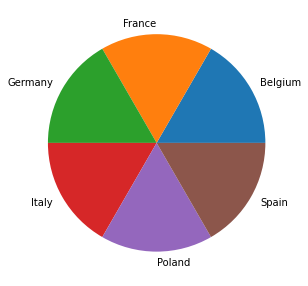

In [76]:
plot_and_display_valuecounts(train, 'country')

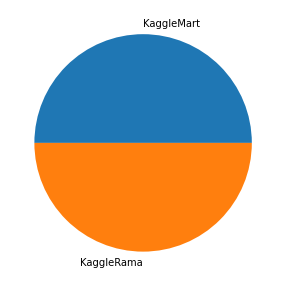

In [77]:
plot_and_display_valuecounts(train, 'store')

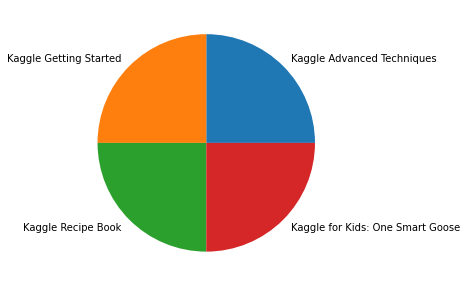

In [78]:
plot_and_display_valuecounts(train, 'product')

In [79]:
train.groupby(["country","store","product"])["num_sold"].count()

country  store       product                         
Belgium  KaggleMart  Kaggle Advanced Techniques          1461
                     Kaggle Getting Started              1461
                     Kaggle Recipe Book                  1461
                     Kaggle for Kids: One Smart Goose    1461
         KaggleRama  Kaggle Advanced Techniques          1461
                     Kaggle Getting Started              1461
                     Kaggle Recipe Book                  1461
                     Kaggle for Kids: One Smart Goose    1461
France   KaggleMart  Kaggle Advanced Techniques          1461
                     Kaggle Getting Started              1461
                     Kaggle Recipe Book                  1461
                     Kaggle for Kids: One Smart Goose    1461
         KaggleRama  Kaggle Advanced Techniques          1461
                     Kaggle Getting Started              1461
                     Kaggle Recipe Book                  1461
                

This gives us 48 univariate time series all of length 1461.
This data is equal amounts

In [80]:
# country, store, product 1주 간격으로 재정렬(num_sold 합)
weekly_df = train.groupby(['country', 'store','product', pd.Grouper(key = 'date', freq = 'W')])["num_sold"].sum().rename("num_sold").reset_index()

# country, store, product 1달 간격으로 재정렬(num_sold 합)
monthly_df = train.groupby(["country","store", "product", pd.Grouper(key="date", freq="MS")])["num_sold"].sum().rename("num_sold").reset_index()
weekly_df.head(5)

country       store                     product       date  num_sold
0  Belgium  KaggleMart  Kaggle Advanced Techniques 2017-01-01       663
1  Belgium  KaggleMart  Kaggle Advanced Techniques 2017-01-08      3362
2  Belgium  KaggleMart  Kaggle Advanced Techniques 2017-01-15      2757
3  Belgium  KaggleMart  Kaggle Advanced Techniques 2017-01-22      2863
4  Belgium  KaggleMart  Kaggle Advanced Techniques 2017-01-29      2924

In [81]:
monthly_df.head(5)

country       store                     product       date  num_sold
0  Belgium  KaggleMart  Kaggle Advanced Techniques 2017-01-01     13345
1  Belgium  KaggleMart  Kaggle Advanced Techniques 2017-02-01     12556
2  Belgium  KaggleMart  Kaggle Advanced Techniques 2017-03-01     14137
3  Belgium  KaggleMart  Kaggle Advanced Techniques 2017-04-01     14575
4  Belgium  KaggleMart  Kaggle Advanced Techniques 2017-05-01     14338

In [82]:
def plot_all(df):
    f, axes = plt.subplots(2, 2, figsize = (20, 15), sharex = True, sharey = True)
    f.tight_layout()
    for n, prod in enumerate(df['product'].unique()):
        plot_df = df.loc[df['product'] == prod]
        sns.lineplot(data = plot_df, x = 'date', y = 'num_sold', hue = 'country', style = 'store', ax = axes[n // 2, n% 2])
        axes[n // 2, n % 2].set_title("Product: "+str(prod))

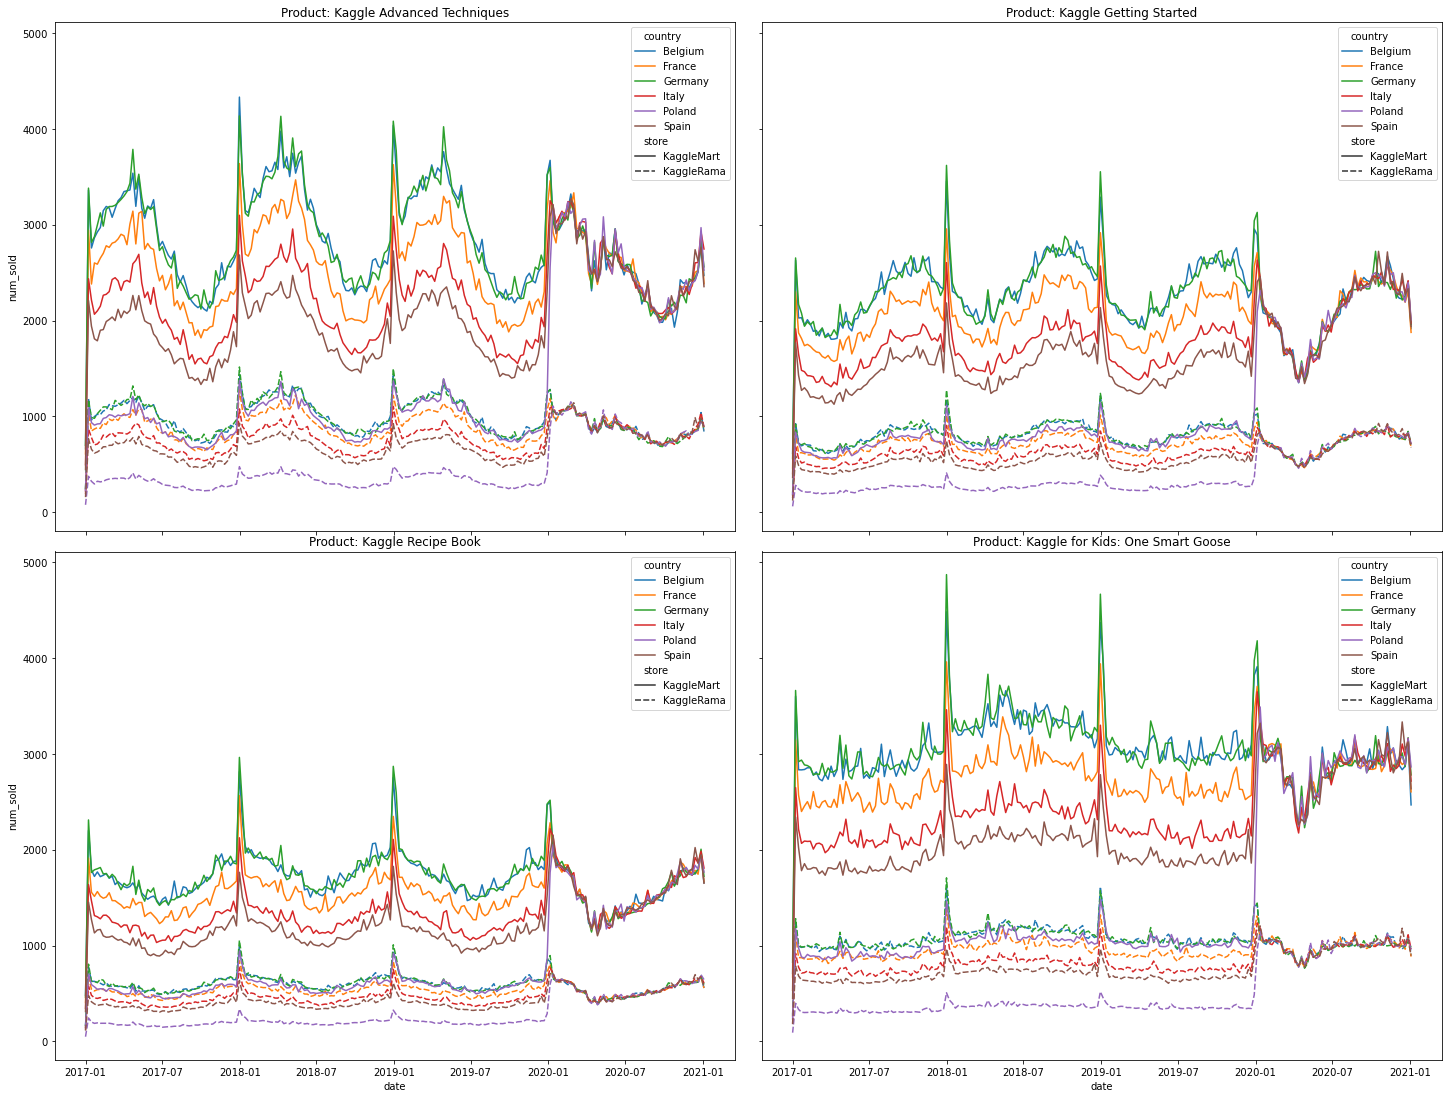

In [83]:
plot_all(weekly_df)

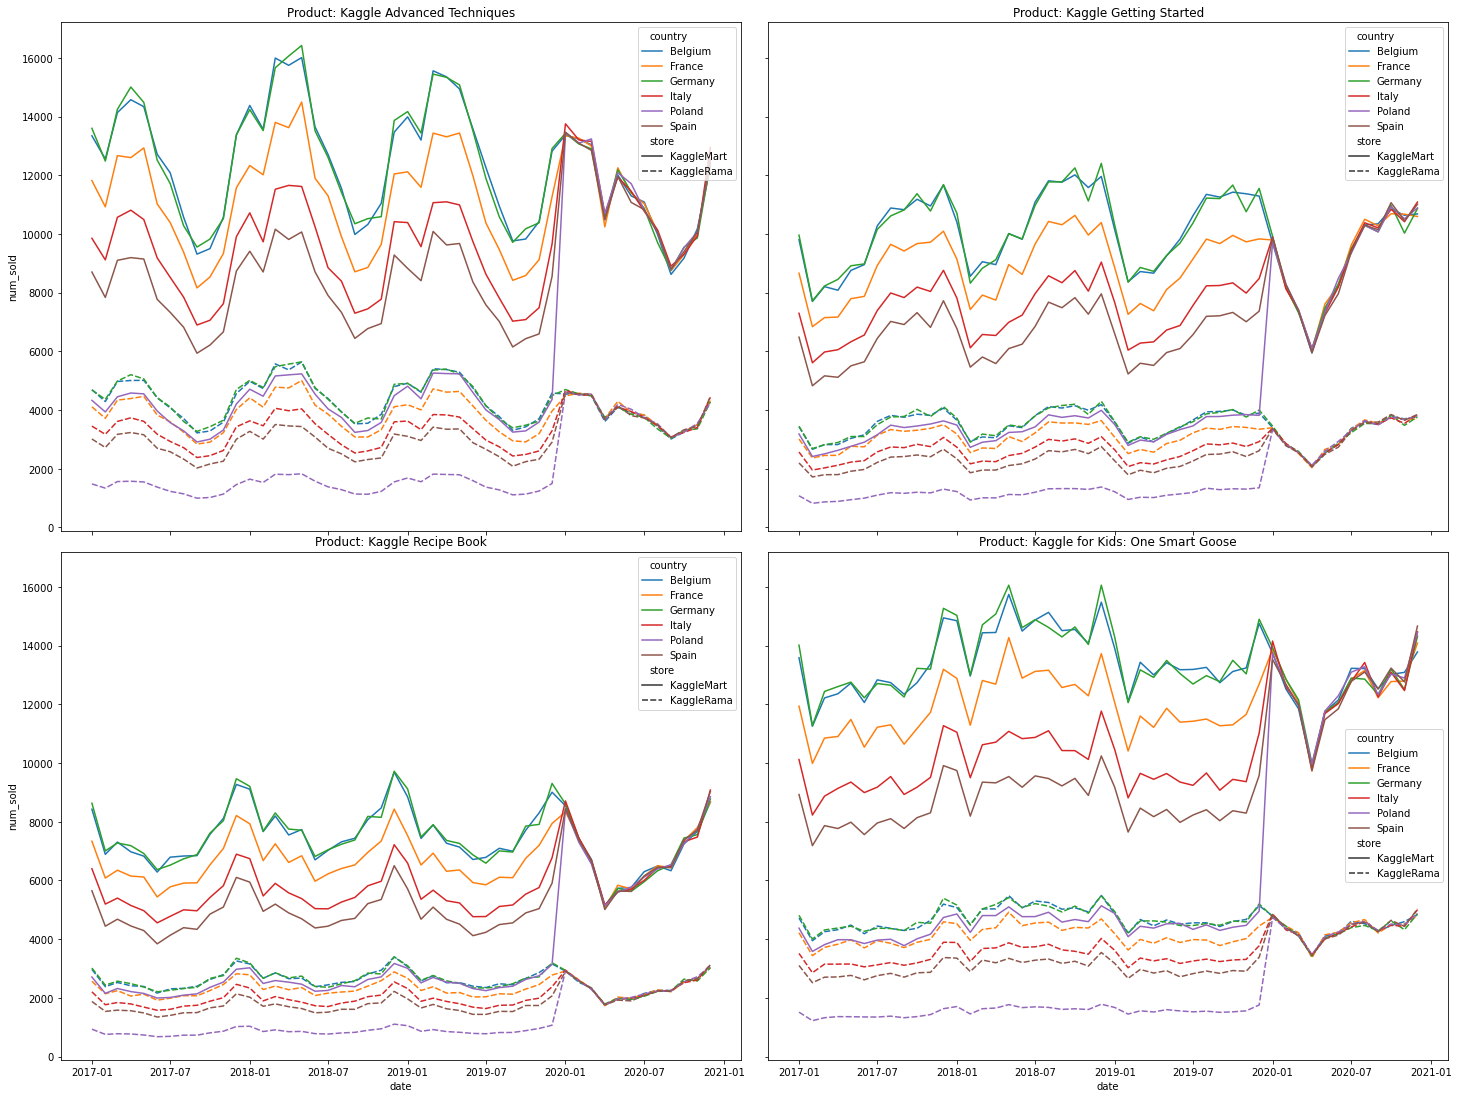

In [84]:
plot_all(monthly_df)

In [85]:
def make_radio(df, index):
    rate = str(index) + "_rate"
    radio = (df.groupby(["date",index])["num_sold"].sum() / df.groupby(["date"])["num_sold"].sum()).reset_index()
    radio.rename(columns = {'num_sold' : rate}, inplace = True)
    weights = df.groupby(index)['num_sold'].sum() / df['num_sold'].sum()
    return radio, weights

In [86]:
store_ratio_over_time, store_weights = make_radio(train, "store")
store_ratio_over_time

date       store  store_rate
0    2017-01-01  KaggleMart    0.736972
1    2017-01-01  KaggleRama    0.263028
2    2017-01-02  KaggleMart    0.739679
3    2017-01-02  KaggleRama    0.260321
4    2017-01-03  KaggleMart    0.741823
...         ...         ...         ...
2917 2020-12-29  KaggleRama    0.263032
2918 2020-12-30  KaggleMart    0.741631
2919 2020-12-30  KaggleRama    0.258369
2920 2020-12-31  KaggleMart    0.738594
2921 2020-12-31  KaggleRama    0.261406

[2922 rows x 3 columns]

In [87]:
train_radio = train_radio.merge(store_ratio_over_time, on = ['date', 'store'], how = 'left')
train_radio

row_id       date  country       store  \
0           0 2017-01-01  Belgium  KaggleMart   
1           1 2017-01-01  Belgium  KaggleMart   
2           2 2017-01-01  Belgium  KaggleMart   
3           3 2017-01-01  Belgium  KaggleMart   
4           4 2017-01-01  Belgium  KaggleRama   
...       ...        ...      ...         ...   
70123   70123 2020-12-31    Spain  KaggleMart   
70124   70124 2020-12-31    Spain  KaggleRama   
70125   70125 2020-12-31    Spain  KaggleRama   
70126   70126 2020-12-31    Spain  KaggleRama   
70127   70127 2020-12-31    Spain  KaggleRama   

                                product  num_sold  store_rate  
0            Kaggle Advanced Techniques       663    0.736972  
1                Kaggle Getting Started       615    0.736972  
2                    Kaggle Recipe Book       480    0.736972  
3      Kaggle for Kids: One Smart Goose       710    0.736972  
4            Kaggle Advanced Techniques       240    0.263028  
...                                 ...       ...         ...  
70123  Kaggle for Kids: One Smart Goose       614    0.738594  
70124        Kaggle Advanced Techniques       215    0.261406  
70125            Kaggle Getting Started       158    0.261406  
70126                Kaggle Recipe Book       135    0.261406  
70127  Kaggle for Kids: One Smart Goose       202    0.261406  

[70128 rows x 7 columns]

In [88]:
store_ratio_over_time['store_rate']

0       0.736972
1       0.263028
2       0.739679
3       0.260321
4       0.741823
          ...   
2917    0.263032
2918    0.741631
2919    0.258369
2920    0.738594
2921    0.261406
Name: store_rate, Length: 2922, dtype: float64

In [89]:
store_weights

store
KaggleMart    0.742515
KaggleRama    0.257485
Name: num_sold, dtype: float64

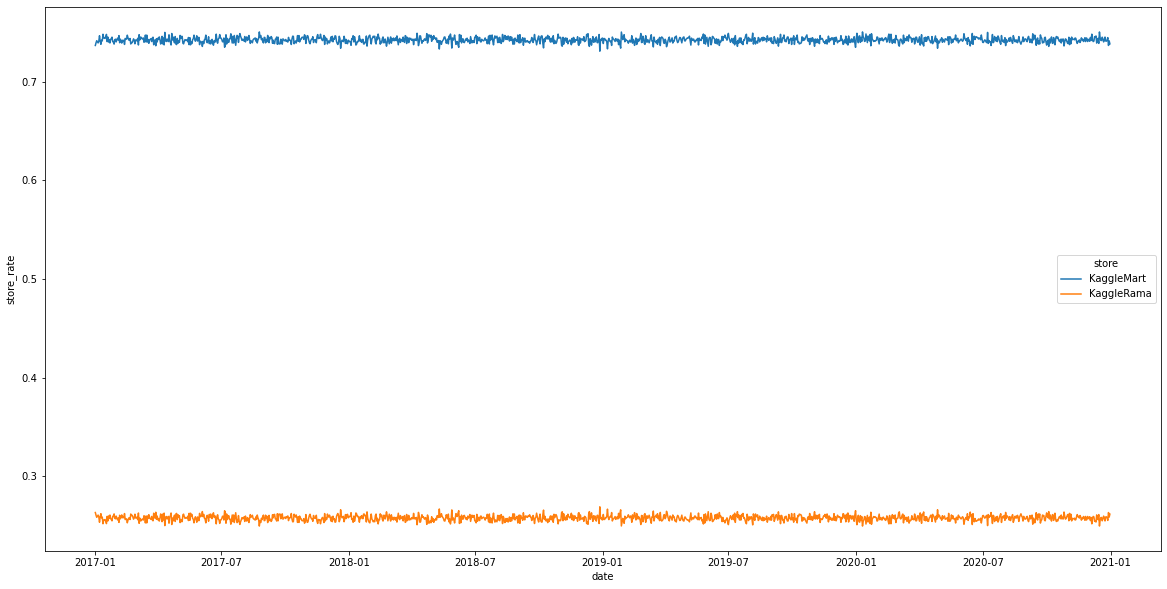

In [90]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.lineplot(data = store_ratio_over_time, x = 'date', y = 'store_rate', hue = 'store')
ax.set_label("Proportion of sales");

In [91]:
def plot_adjusted_store(df):
    new_df = df.copy()
    weights = store_weights.loc["KaggleMart"] / store_weights
    for store in weights.index:
        new_df.loc[new_df["store"] == store, "num_sold"] = new_df.loc[new_df["store"] == store, "num_sold"] * weights[store]
    plot_all(new_df)

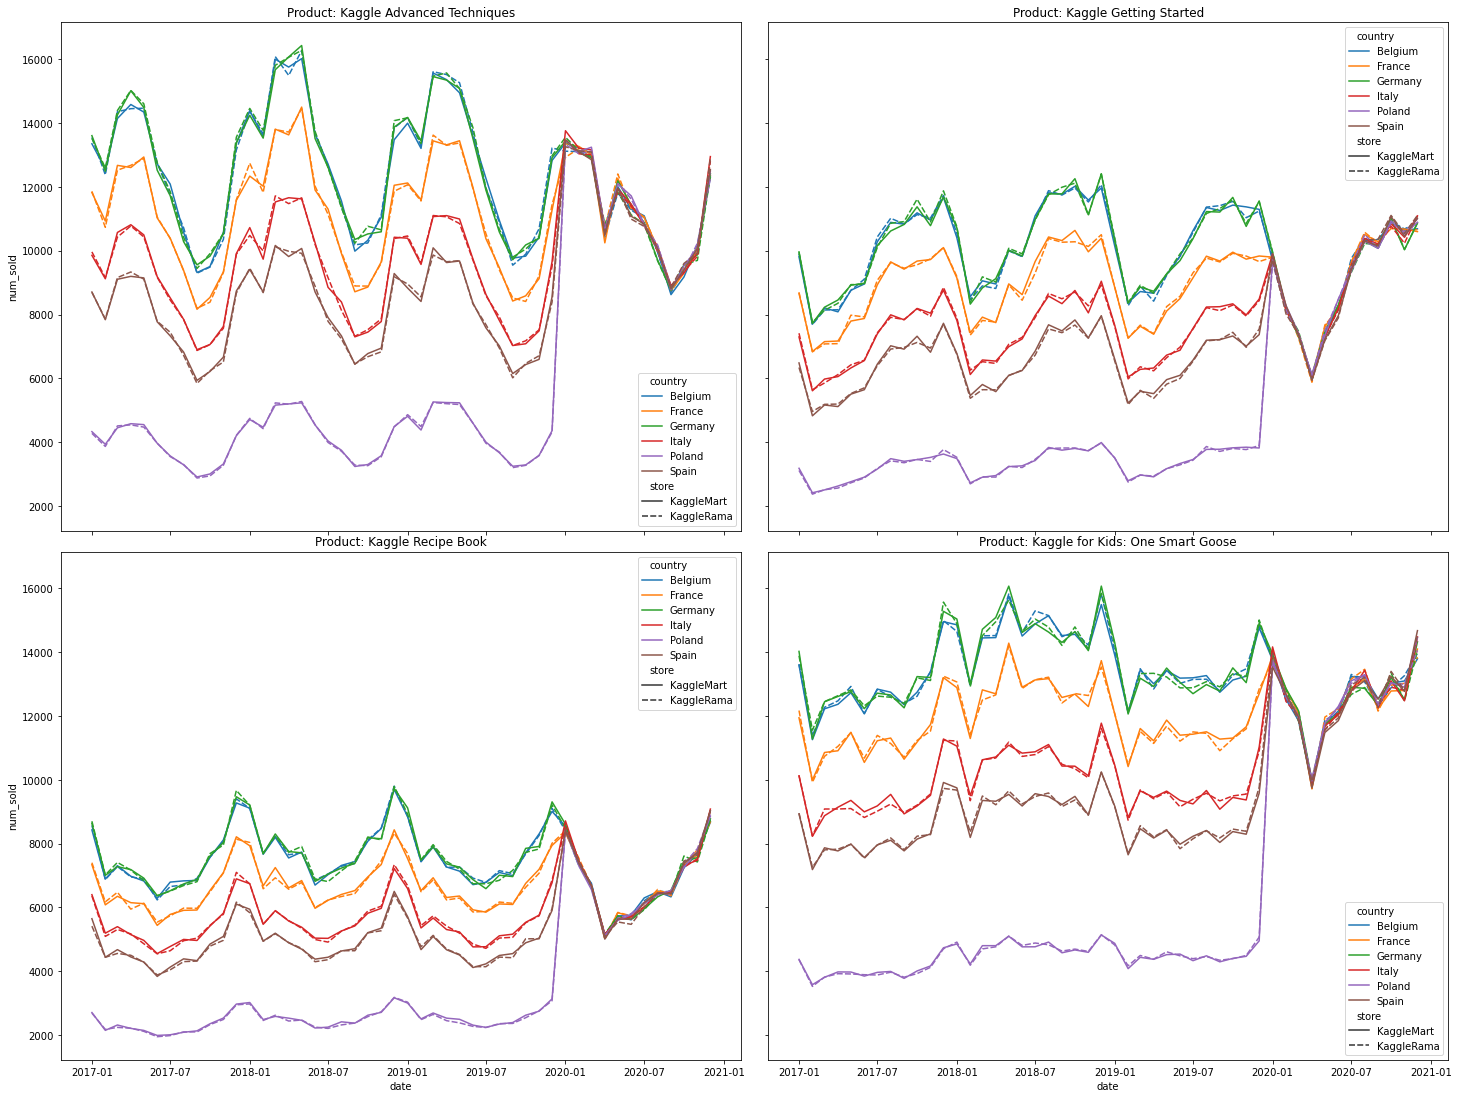

In [92]:
plot_adjusted_store(monthly_df)

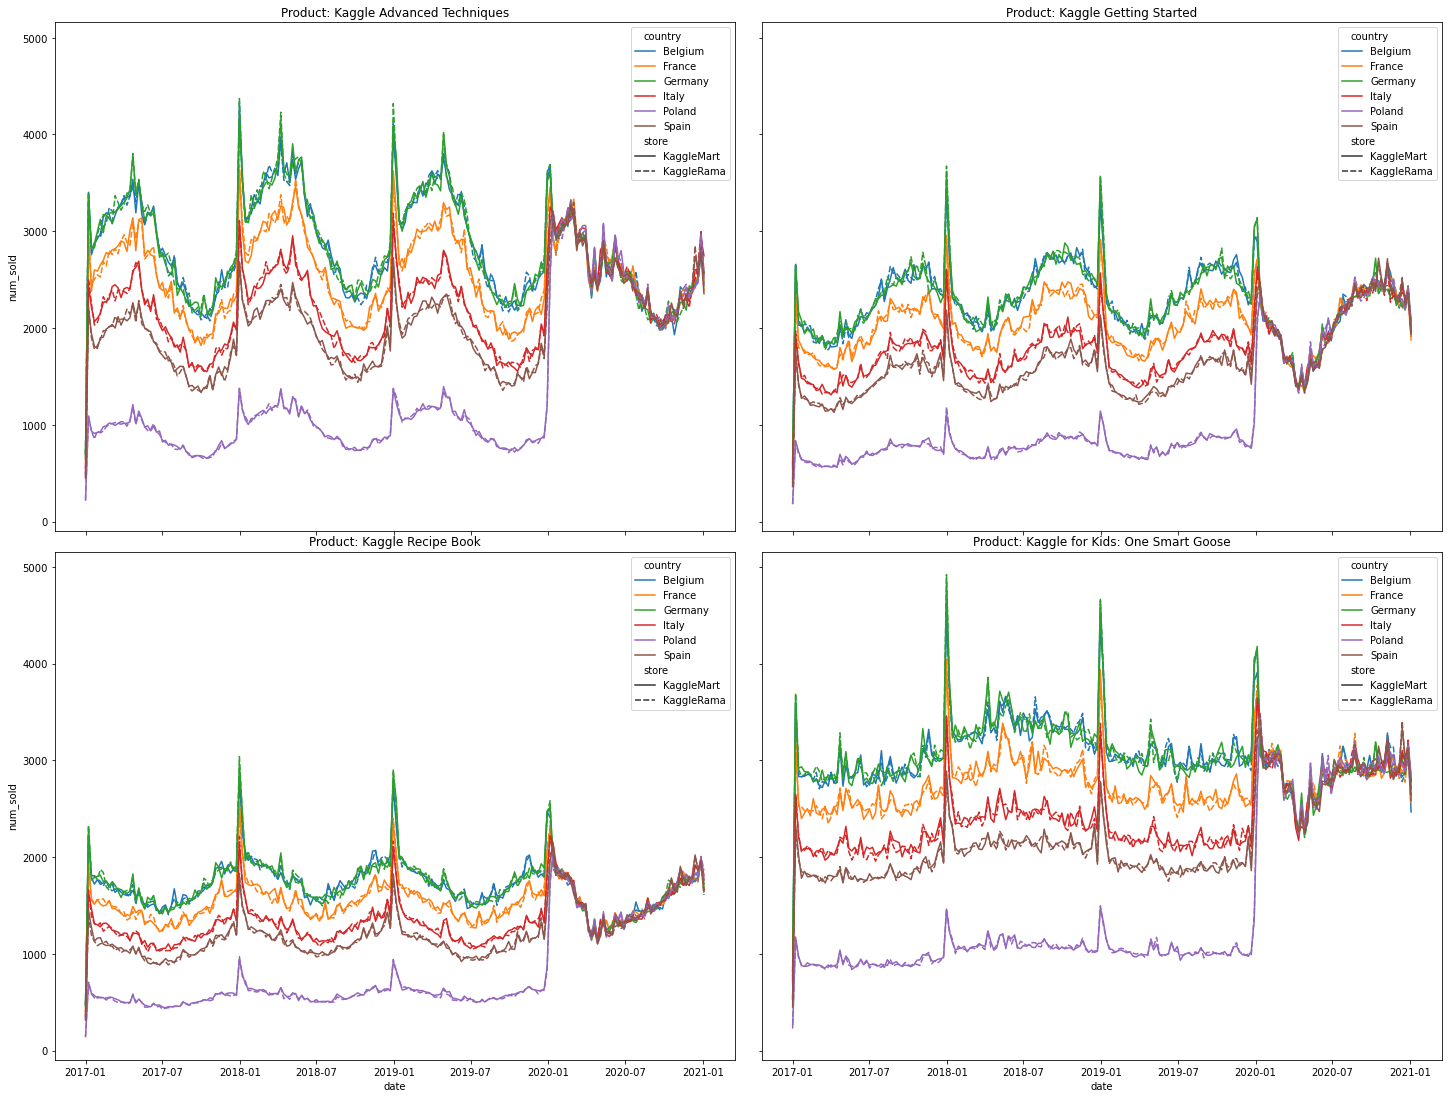

In [93]:
plot_adjusted_store(weekly_df)

In [94]:
country_ratio_over_time, country_weights = make_radio(train, "country")
country_ratio_over_time

date  country  country_rate
0    2017-01-01  Belgium      0.216258
1    2017-01-01   France      0.191441
2    2017-01-01  Germany      0.223880
3    2017-01-01    Italy      0.158351
4    2017-01-01   Poland      0.069958
...         ...      ...           ...
8761 2020-12-31   France      0.159591
8762 2020-12-31  Germany      0.172803
8763 2020-12-31    Italy      0.178028
8764 2020-12-31   Poland      0.172744
8765 2020-12-31    Spain      0.159474

[8766 rows x 3 columns]

In [95]:
train_radio = train_radio.merge(country_ratio_over_time, on = ['date', 'country'], how = 'left')
train_radio

row_id       date  country       store  \
0           0 2017-01-01  Belgium  KaggleMart   
1           1 2017-01-01  Belgium  KaggleMart   
2           2 2017-01-01  Belgium  KaggleMart   
3           3 2017-01-01  Belgium  KaggleMart   
4           4 2017-01-01  Belgium  KaggleRama   
...       ...        ...      ...         ...   
70123   70123 2020-12-31    Spain  KaggleMart   
70124   70124 2020-12-31    Spain  KaggleRama   
70125   70125 2020-12-31    Spain  KaggleRama   
70126   70126 2020-12-31    Spain  KaggleRama   
70127   70127 2020-12-31    Spain  KaggleRama   

                                product  num_sold  store_rate  country_rate  
0            Kaggle Advanced Techniques       663    0.736972      0.216258  
1                Kaggle Getting Started       615    0.736972      0.216258  
2                    Kaggle Recipe Book       480    0.736972      0.216258  
3      Kaggle for Kids: One Smart Goose       710    0.736972      0.216258  
4            Kaggle Advanced Techniques       240    0.263028      0.216258  
...                                 ...       ...         ...           ...  
70123  Kaggle for Kids: One Smart Goose       614    0.738594      0.159474  
70124        Kaggle Advanced Techniques       215    0.261406      0.159474  
70125            Kaggle Getting Started       158    0.261406      0.159474  
70126                Kaggle Recipe Book       135    0.261406      0.159474  
70127  Kaggle for Kids: One Smart Goose       202    0.261406      0.159474  

[70128 rows x 8 columns]

In [96]:
country_weights = train.loc[train["date"] < "2020-01-01"].groupby('country')['num_sold'].sum() / train.loc[train["date"] < "2020-01-01", 'num_sold'].sum()
country_weights

country
Belgium    0.218930
France     0.191360
Germany    0.219586
Italy      0.159383
Poland     0.071348
Spain      0.139393
Name: num_sold, dtype: float64

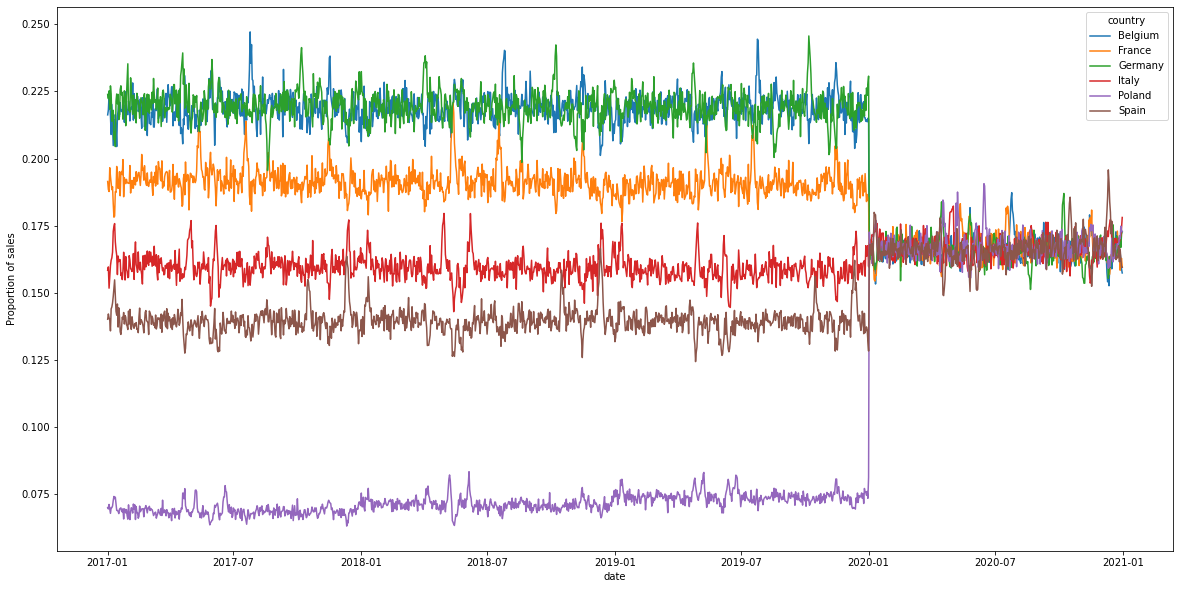

In [99]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = country_ratio_over_time, x="date", y="country_rate", hue="country");
ax.set_ylabel("Proportion of sales");

In [100]:
train

row_id       date  country       store  \
0           0 2017-01-01  Belgium  KaggleMart   
1           1 2017-01-01  Belgium  KaggleMart   
2           2 2017-01-01  Belgium  KaggleMart   
3           3 2017-01-01  Belgium  KaggleMart   
4           4 2017-01-01  Belgium  KaggleRama   
...       ...        ...      ...         ...   
70123   70123 2020-12-31    Spain  KaggleMart   
70124   70124 2020-12-31    Spain  KaggleRama   
70125   70125 2020-12-31    Spain  KaggleRama   
70126   70126 2020-12-31    Spain  KaggleRama   
70127   70127 2020-12-31    Spain  KaggleRama   

                                product  num_sold  
0            Kaggle Advanced Techniques       663  
1                Kaggle Getting Started       615  
2                    Kaggle Recipe Book       480  
3      Kaggle for Kids: One Smart Goose       710  
4            Kaggle Advanced Techniques       240  
...                                 ...       ...  
70123  Kaggle for Kids: One Smart Goose       614  
70124        Kaggle Advanced Techniques       215  
70125            Kaggle Getting Started       158  
70126                Kaggle Recipe Book       135  
70127  Kaggle for Kids: One Smart Goose       202  

[70128 rows x 6 columns]

In [101]:
def plot_adjust_country(df):
    new_df = df.copy()
    
    weights = country_weights.loc["Belgium"] / country_weights
    
    for country in weights.index:
        new_df.loc[(new_df["country"] == country) & (new_df["date"] < "2020-01-01"), "num_sold"] = new_df.loc[(new_df["country"] == country) & (new_df["date"] < "2020-01-01"), "num_sold"] *  weights[country]
    #plot_country_product(new_df)
    plot_all(new_df)

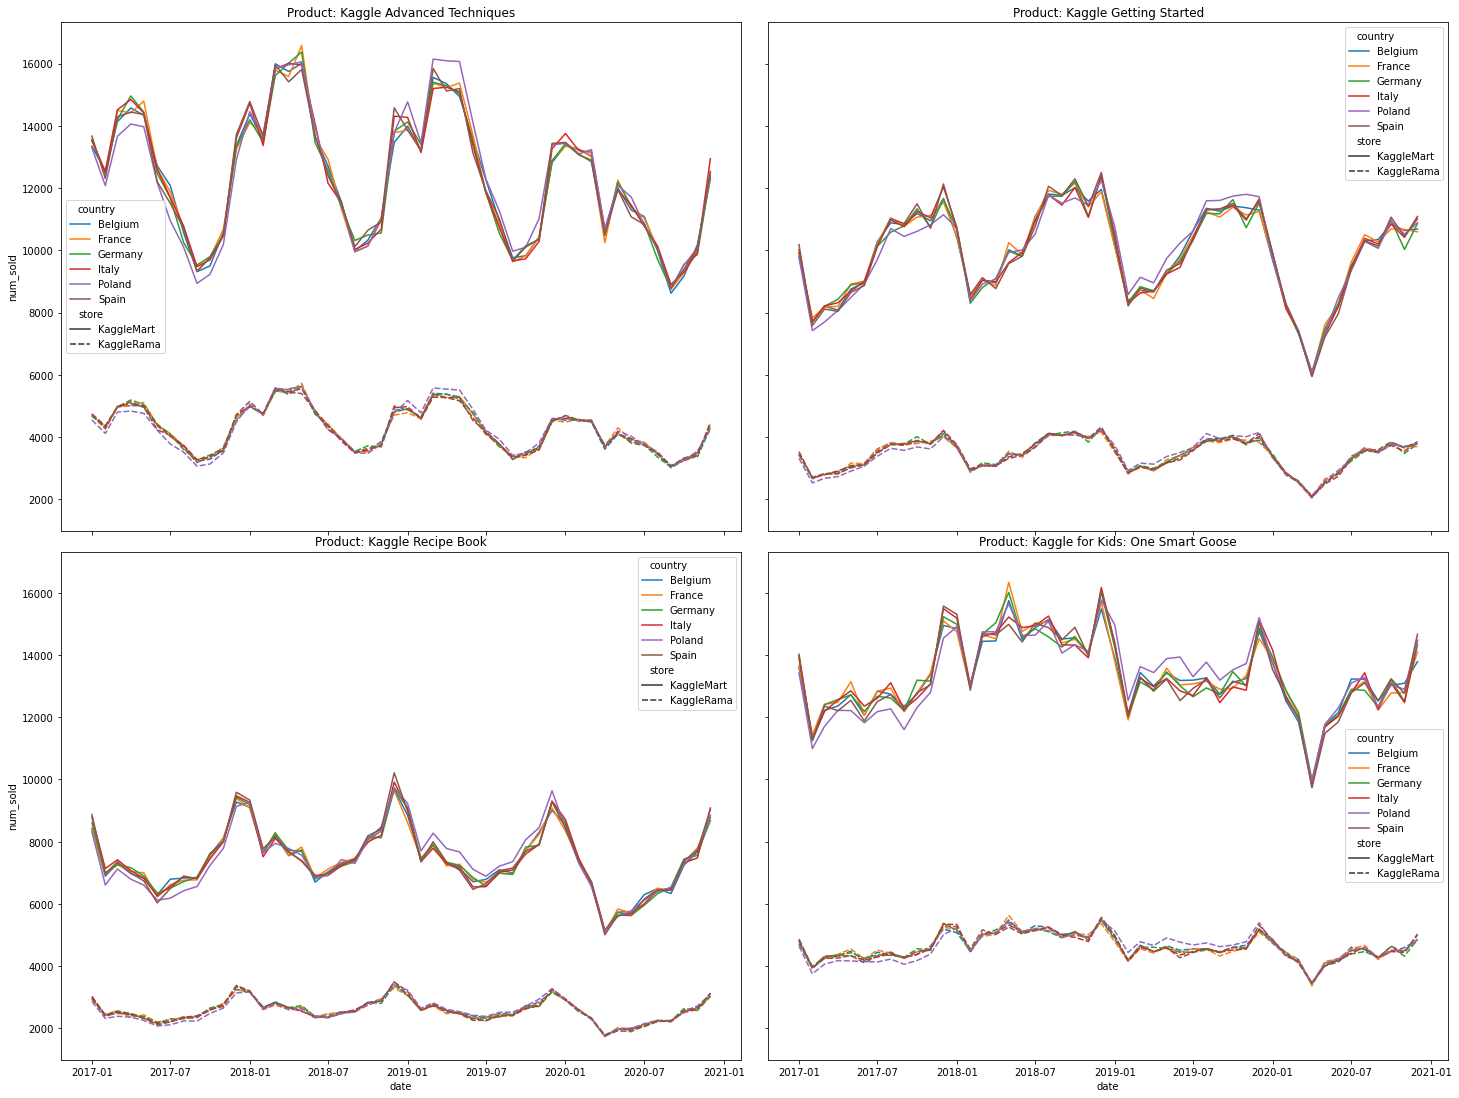

In [102]:
plot_adjust_country(monthly_df)

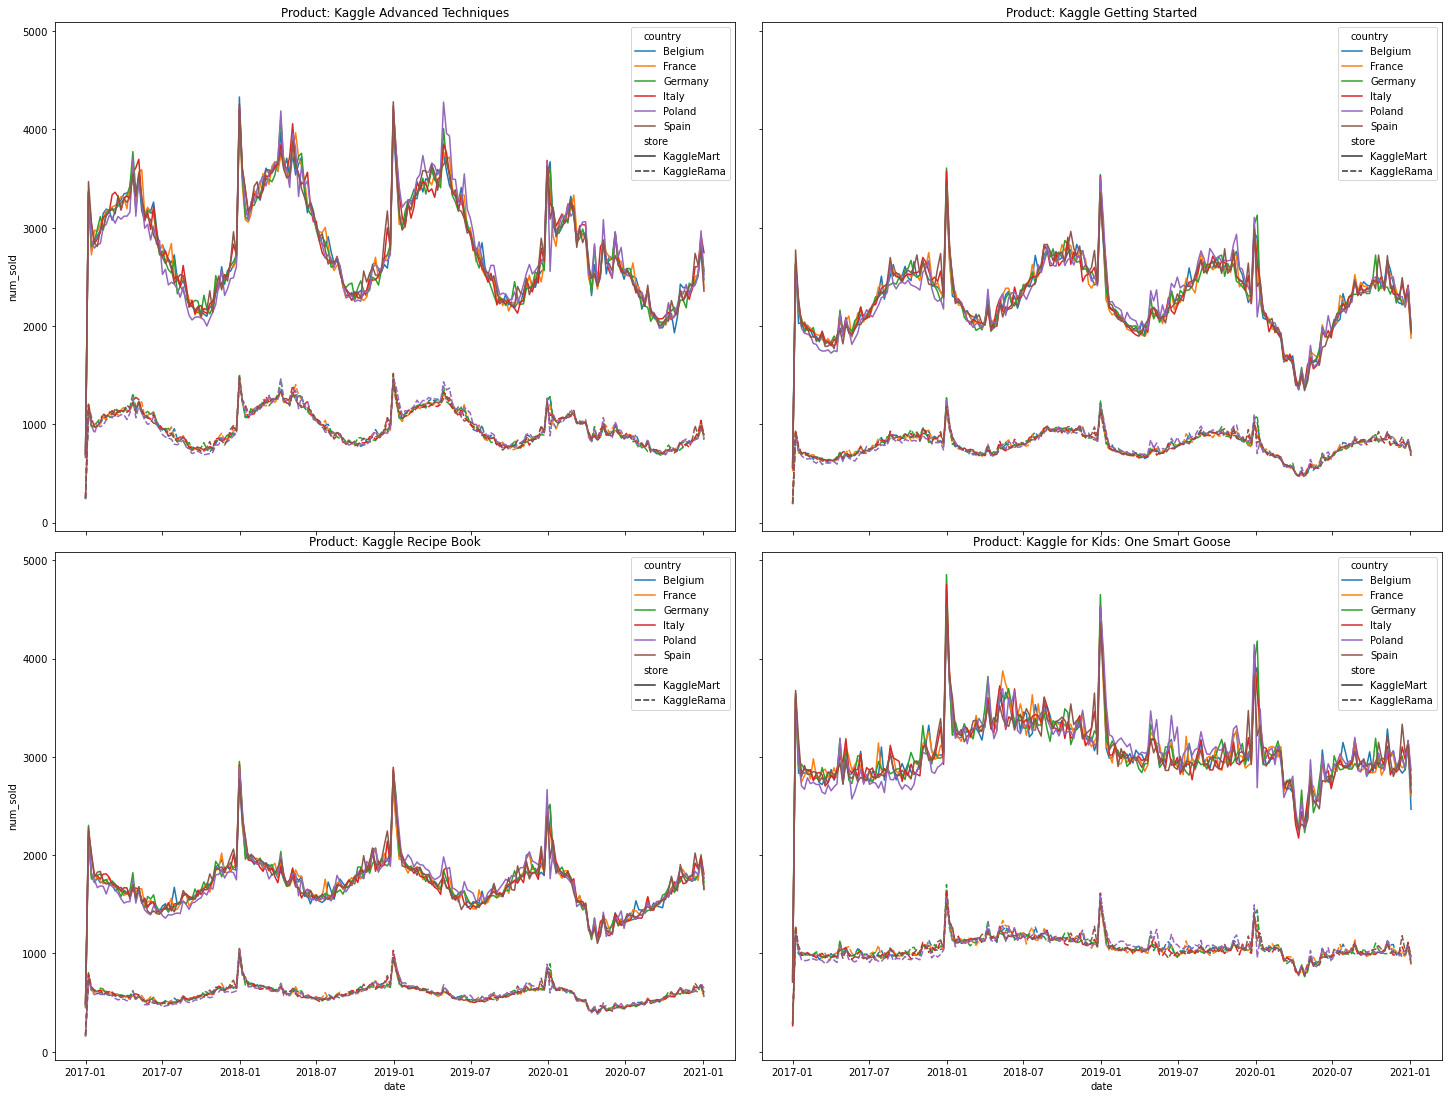

In [103]:
plot_adjust_country(weekly_df)

In [106]:
product_df = train.groupby(["date","product"])["num_sold"].sum().reset_index()
product_df

date                           product  num_sold
0    2017-01-01        Kaggle Advanced Techniques      4267
1    2017-01-01            Kaggle Getting Started      3492
2    2017-01-01                Kaggle Recipe Book      2900
3    2017-01-01  Kaggle for Kids: One Smart Goose      4693
4    2017-01-02        Kaggle Advanced Techniques      3242
...         ...                               ...       ...
5839 2020-12-30  Kaggle for Kids: One Smart Goose      5699
5840 2020-12-31        Kaggle Advanced Techniques      4968
5841 2020-12-31            Kaggle Getting Started      3780
5842 2020-12-31                Kaggle Recipe Book      3301
5843 2020-12-31  Kaggle for Kids: One Smart Goose      4982

[5844 rows x 3 columns]

In [107]:
product_df.rename(columns = {'num_sold' : 'product_total_sell'}, inplace = True)
product_df

date                           product  product_total_sell
0    2017-01-01        Kaggle Advanced Techniques                4267
1    2017-01-01            Kaggle Getting Started                3492
2    2017-01-01                Kaggle Recipe Book                2900
3    2017-01-01  Kaggle for Kids: One Smart Goose                4693
4    2017-01-02        Kaggle Advanced Techniques                3242
...         ...                               ...                 ...
5839 2020-12-30  Kaggle for Kids: One Smart Goose                5699
5840 2020-12-31        Kaggle Advanced Techniques                4968
5841 2020-12-31            Kaggle Getting Started                3780
5842 2020-12-31                Kaggle Recipe Book                3301
5843 2020-12-31  Kaggle for Kids: One Smart Goose                4982

[5844 rows x 3 columns]

In [108]:
train_radio = train_radio.merge(product_df, on = ['date', 'product'], how = 'left')
train_radio

row_id       date  country       store  \
0           0 2017-01-01  Belgium  KaggleMart   
1           1 2017-01-01  Belgium  KaggleMart   
2           2 2017-01-01  Belgium  KaggleMart   
3           3 2017-01-01  Belgium  KaggleMart   
4           4 2017-01-01  Belgium  KaggleRama   
...       ...        ...      ...         ...   
70123   70123 2020-12-31    Spain  KaggleMart   
70124   70124 2020-12-31    Spain  KaggleRama   
70125   70125 2020-12-31    Spain  KaggleRama   
70126   70126 2020-12-31    Spain  KaggleRama   
70127   70127 2020-12-31    Spain  KaggleRama   

                                product  num_sold  store_rate  country_rate  \
0            Kaggle Advanced Techniques       663    0.736972      0.216258   
1                Kaggle Getting Started       615    0.736972      0.216258   
2                    Kaggle Recipe Book       480    0.736972      0.216258   
3      Kaggle for Kids: One Smart Goose       710    0.736972      0.216258   
4            Kaggle Advanced Techniques       240    0.263028      0.216258   
...                                 ...       ...         ...           ...   
70123  Kaggle for Kids: One Smart Goose       614    0.738594      0.159474   
70124        Kaggle Advanced Techniques       215    0.261406      0.159474   
70125            Kaggle Getting Started       158    0.261406      0.159474   
70126                Kaggle Recipe Book       135    0.261406      0.159474   
70127  Kaggle for Kids: One Smart Goose       202    0.261406      0.159474   

       product_total_sell  
0                    4267  
1                    3492  
2                    2900  
3                    4693  
4                    4267  
...                   ...  
70123                4982  
70124                4968  
70125                3780  
70126                3301  
70127                4982  

[70128 rows x 9 columns]

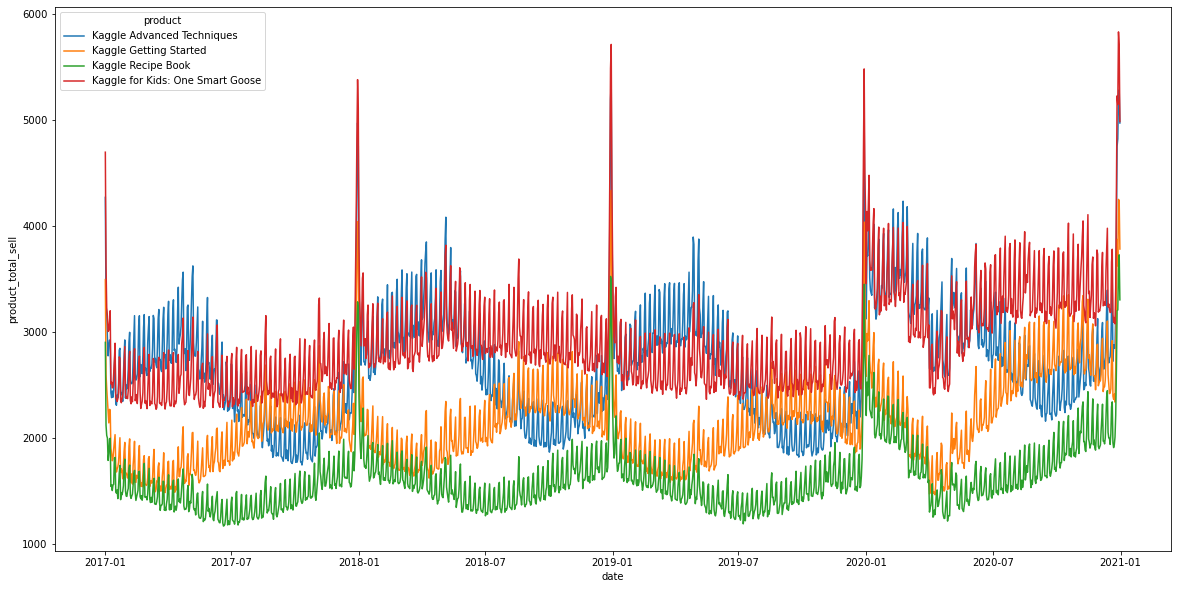

In [109]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=product_df, x="date", y="product_total_sell", hue="product");

In [112]:
product_ratio_df = product_df.pivot(index="date", columns="product", values="product_total_sell")
product_ratio_df = product_ratio_df.apply(lambda x: x/x.sum(),axis=1)
product_ratio_df = product_ratio_df.stack().rename("product_radio").reset_index()
product_ratio_df

date                           product  product_radio
0    2017-01-01        Kaggle Advanced Techniques       0.277944
1    2017-01-01            Kaggle Getting Started       0.227462
2    2017-01-01                Kaggle Recipe Book       0.188900
3    2017-01-01  Kaggle for Kids: One Smart Goose       0.305693
4    2017-01-02        Kaggle Advanced Techniques       0.280014
...         ...                               ...            ...
5839 2020-12-30  Kaggle for Kids: One Smart Goose       0.300929
5840 2020-12-31        Kaggle Advanced Techniques       0.291703
5841 2020-12-31            Kaggle Getting Started       0.221948
5842 2020-12-31                Kaggle Recipe Book       0.193823
5843 2020-12-31  Kaggle for Kids: One Smart Goose       0.292525

[5844 rows x 3 columns]

In [113]:
train_radio = train_radio.merge(product_ratio_df, on = ['date', 'product'], how = 'left')
train_radio

row_id       date  country       store  \
0           0 2017-01-01  Belgium  KaggleMart   
1           1 2017-01-01  Belgium  KaggleMart   
2           2 2017-01-01  Belgium  KaggleMart   
3           3 2017-01-01  Belgium  KaggleMart   
4           4 2017-01-01  Belgium  KaggleRama   
...       ...        ...      ...         ...   
70123   70123 2020-12-31    Spain  KaggleMart   
70124   70124 2020-12-31    Spain  KaggleRama   
70125   70125 2020-12-31    Spain  KaggleRama   
70126   70126 2020-12-31    Spain  KaggleRama   
70127   70127 2020-12-31    Spain  KaggleRama   

                                product  num_sold  store_rate  country_rate  \
0            Kaggle Advanced Techniques       663    0.736972      0.216258   
1                Kaggle Getting Started       615    0.736972      0.216258   
2                    Kaggle Recipe Book       480    0.736972      0.216258   
3      Kaggle for Kids: One Smart Goose       710    0.736972      0.216258   
4            Kaggle Advanced Techniques       240    0.263028      0.216258   
...                                 ...       ...         ...           ...   
70123  Kaggle for Kids: One Smart Goose       614    0.738594      0.159474   
70124        Kaggle Advanced Techniques       215    0.261406      0.159474   
70125            Kaggle Getting Started       158    0.261406      0.159474   
70126                Kaggle Recipe Book       135    0.261406      0.159474   
70127  Kaggle for Kids: One Smart Goose       202    0.261406      0.159474   

       product_total_sell  product_radio  
0                    4267       0.277944  
1                    3492       0.227462  
2                    2900       0.188900  
3                    4693       0.305693  
4                    4267       0.277944  
...                   ...            ...  
70123                4982       0.292525  
70124                4968       0.291703  
70125                3780       0.221948  
70126                3301       0.193823  
70127                4982       0.292525  

[70128 rows x 10 columns]

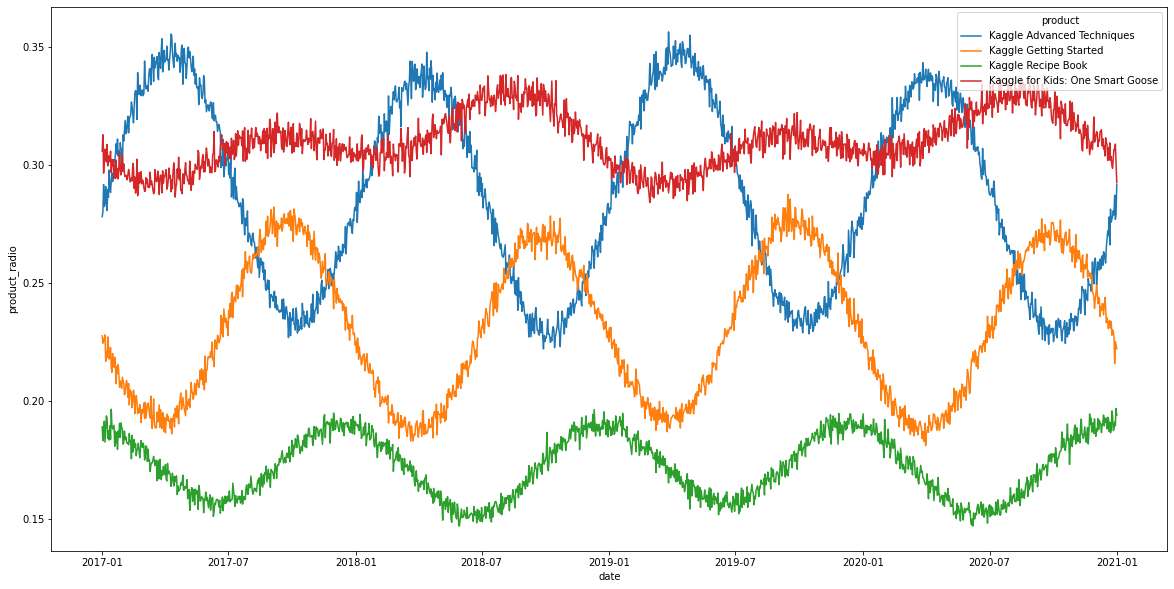

In [115]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = product_ratio_df, x="date", y="product_radio", hue="product");

In [116]:
train = train.groupby(["date"])["num_sold"].sum().reset_index()

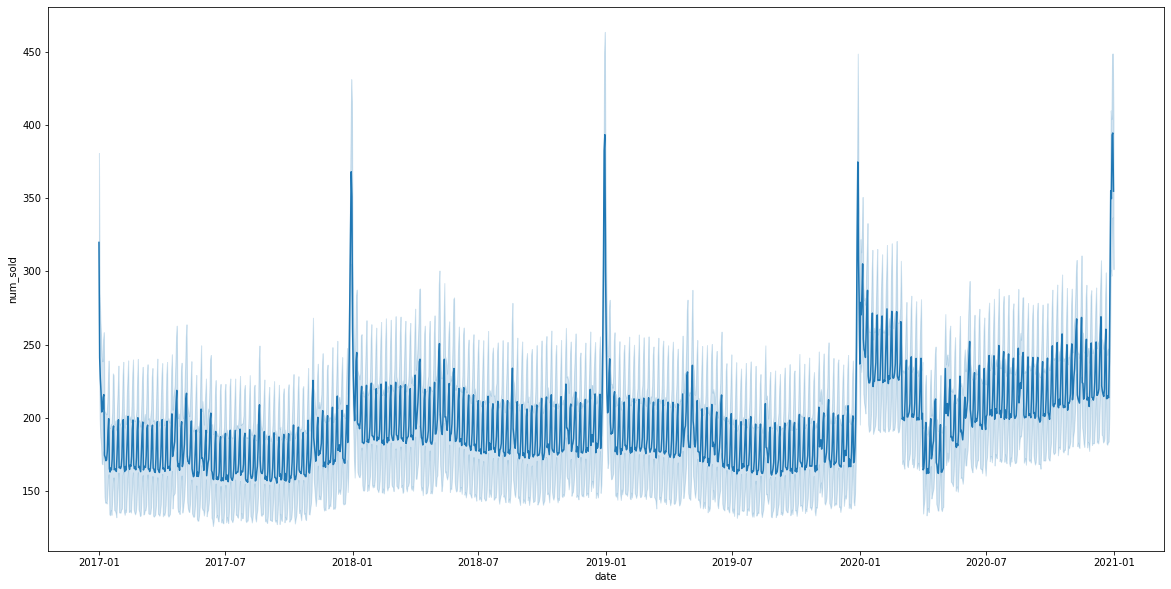

In [127]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = train_radio, x="date", y="num_sold");

In [118]:
weekly_df = train.groupby([pd.Grouper(key="date", freq="W")])["num_sold"].sum().rename("num_sold").reset_index()
monthly_df = train.groupby([pd.Grouper(key="date", freq="MS")])["num_sold"].sum().rename("num_sold").reset_index()

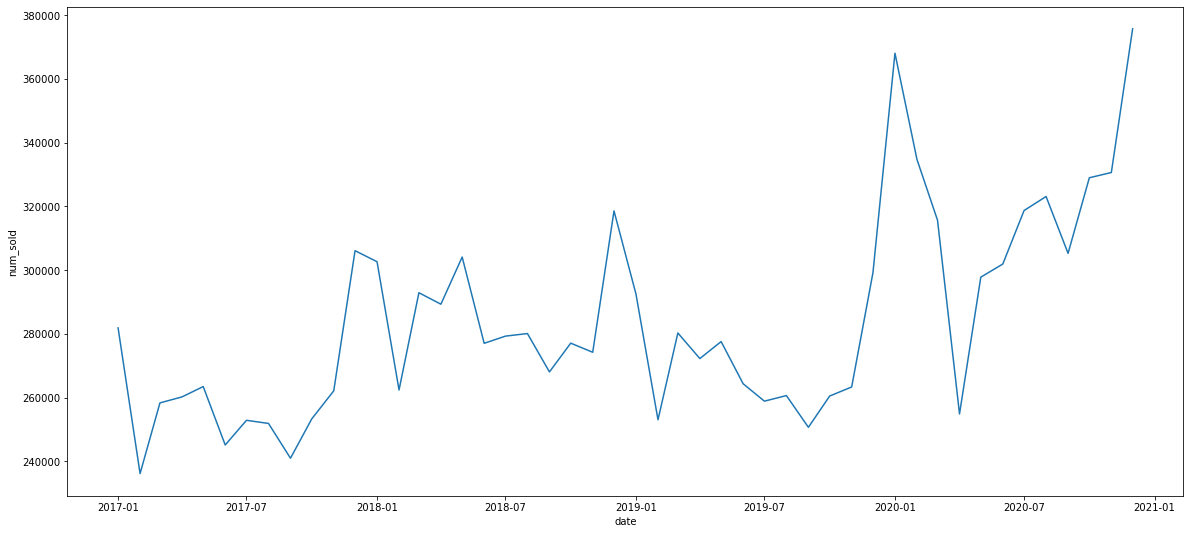

In [119]:
f,ax = plt.subplots(figsize=(20,9))
sns.lineplot(data=monthly_df, x="date", y="num_sold");

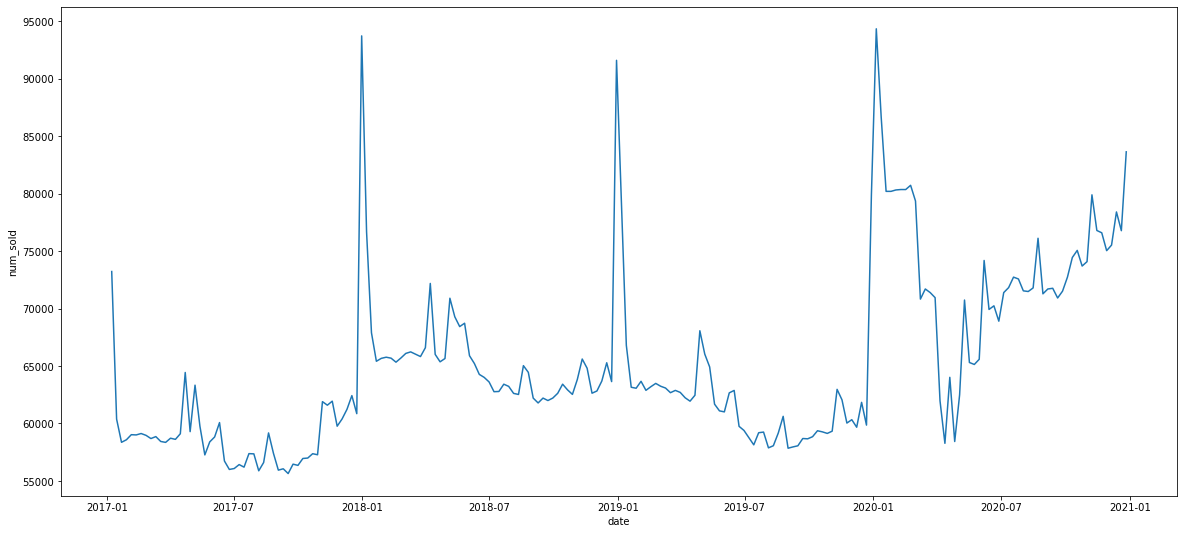

In [120]:
f,ax = plt.subplots(figsize=(20,9))
sns.lineplot(data=weekly_df[1:-1], x="date", y="num_sold");

In [151]:
train_radio["month"] = train_radio["date"].dt.month
train_radio["day_of_week"] = train_radio["date"].dt.dayofweek
train_radio["day_of_year"] = train_radio["date"].dt.dayofyear
#     윤년 빼는 이유 : dayofyear시 1년의 수가 365가 아닌 366으로 된다.
train_radio["day_of_year"] = train_radio.apply(lambda x: x["day_of_year"]-1 if x["date"] > pd.Timestamp("2020-02-29") else x["day_of_year"], axis=1)
# df["day_of_year"] = df.apply(lambda x: x["day_of_year"]-1 if x["date"] > pd.Timestamp("2020-02-29") else x["day_of_year"], axis=1)

def plot_seasonality(df, x_axis):
    #account for leap year
#     윤년 빼는 이유 : dayofyear시 1년의 수가 365가 아닌 366으로 된다.
        
    df_no_2020 = df.loc[df["date"] < "2020-01-01"]

    f,axes = plt.subplots(2,1,figsize=(20,16))
    sns.lineplot(data=df, x=x_axis, y="num_sold", ax=axes[0]);
    sns.lineplot(data=df_no_2020, x=x_axis, y="num_sold", ax=axes[1]);
    axes[0].set_title("{} Seasonality - all years".format(x_axis))
    axes[1].set_title("{} Seasonality - not including 2020".format(x_axis))

In [152]:
train_radio

row_id       date  country       store  \
0           0 2017-01-01  Belgium  KaggleMart   
1           1 2017-01-01  Belgium  KaggleMart   
2           2 2017-01-01  Belgium  KaggleMart   
3           3 2017-01-01  Belgium  KaggleMart   
4           4 2017-01-01  Belgium  KaggleRama   
...       ...        ...      ...         ...   
70123   70123 2020-12-31    Spain  KaggleMart   
70124   70124 2020-12-31    Spain  KaggleRama   
70125   70125 2020-12-31    Spain  KaggleRama   
70126   70126 2020-12-31    Spain  KaggleRama   
70127   70127 2020-12-31    Spain  KaggleRama   

                                product  num_sold  store_rate  country_rate  \
0            Kaggle Advanced Techniques       663    0.736972      0.216258   
1                Kaggle Getting Started       615    0.736972      0.216258   
2                    Kaggle Recipe Book       480    0.736972      0.216258   
3      Kaggle for Kids: One Smart Goose       710    0.736972      0.216258   
4            Kaggle Advanced Techniques       240    0.263028      0.216258   
...                                 ...       ...         ...           ...   
70123  Kaggle for Kids: One Smart Goose       614    0.738594      0.159474   
70124        Kaggle Advanced Techniques       215    0.261406      0.159474   
70125            Kaggle Getting Started       158    0.261406      0.159474   
70126                Kaggle Recipe Book       135    0.261406      0.159474   
70127  Kaggle for Kids: One Smart Goose       202    0.261406      0.159474   

       product_total_sell  product_radio  month  day_of_week  day_of_year  
0                    4267       0.277944      1            6            1  
1                    3492       0.227462      1            6            1  
2                    2900       0.188900      1            6            1  
3                    4693       0.305693      1            6            1  
4                    4267       0.277944      1            6            1  
...                   ...            ...    ...          ...          ...  
70123                4982       0.292525     12            3          365  
70124                4968       0.291703     12            3          365  
70125                3780       0.221948     12            3          365  
70126                3301       0.193823     12            3          365  
70127                4982       0.292525     12            3          365  

[70128 rows x 13 columns]

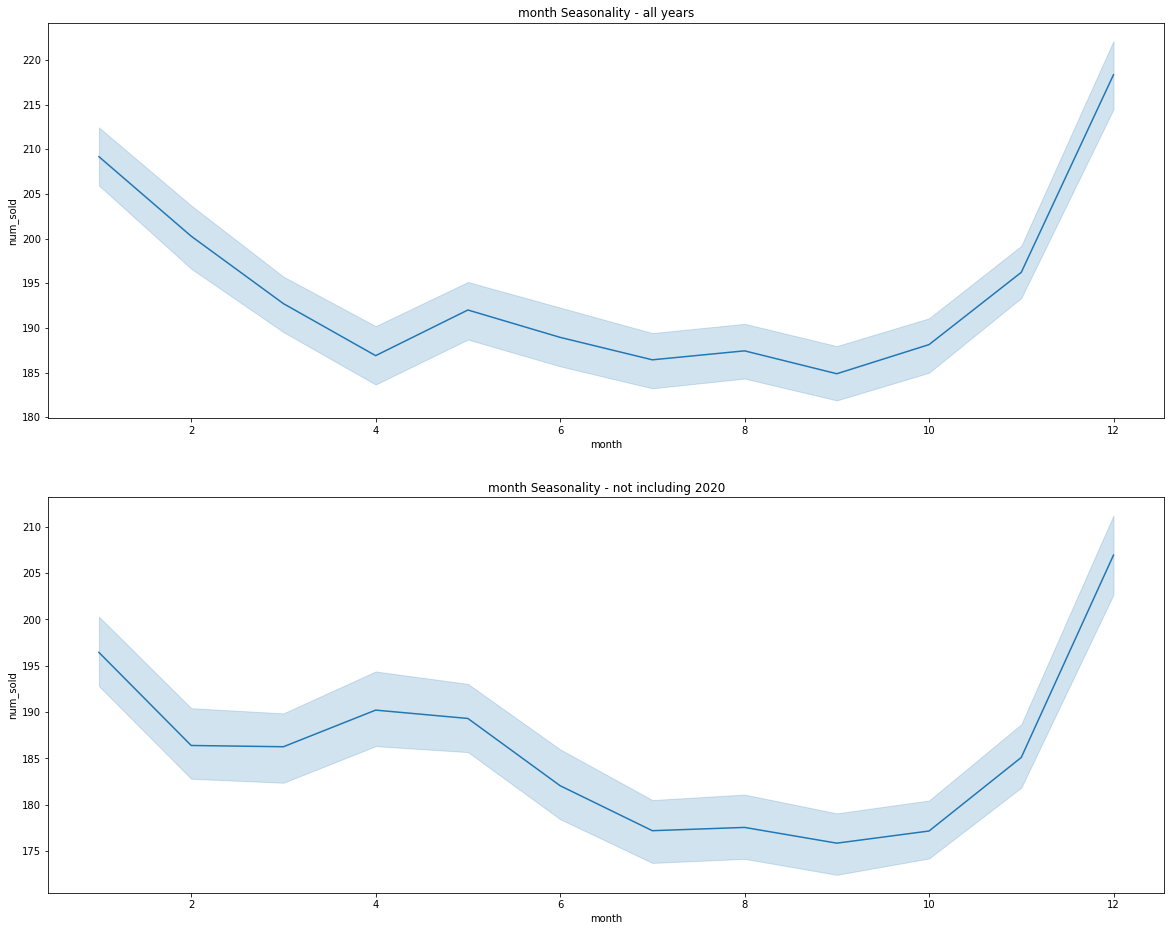

In [153]:
plot_seasonality(train_radio, "month")

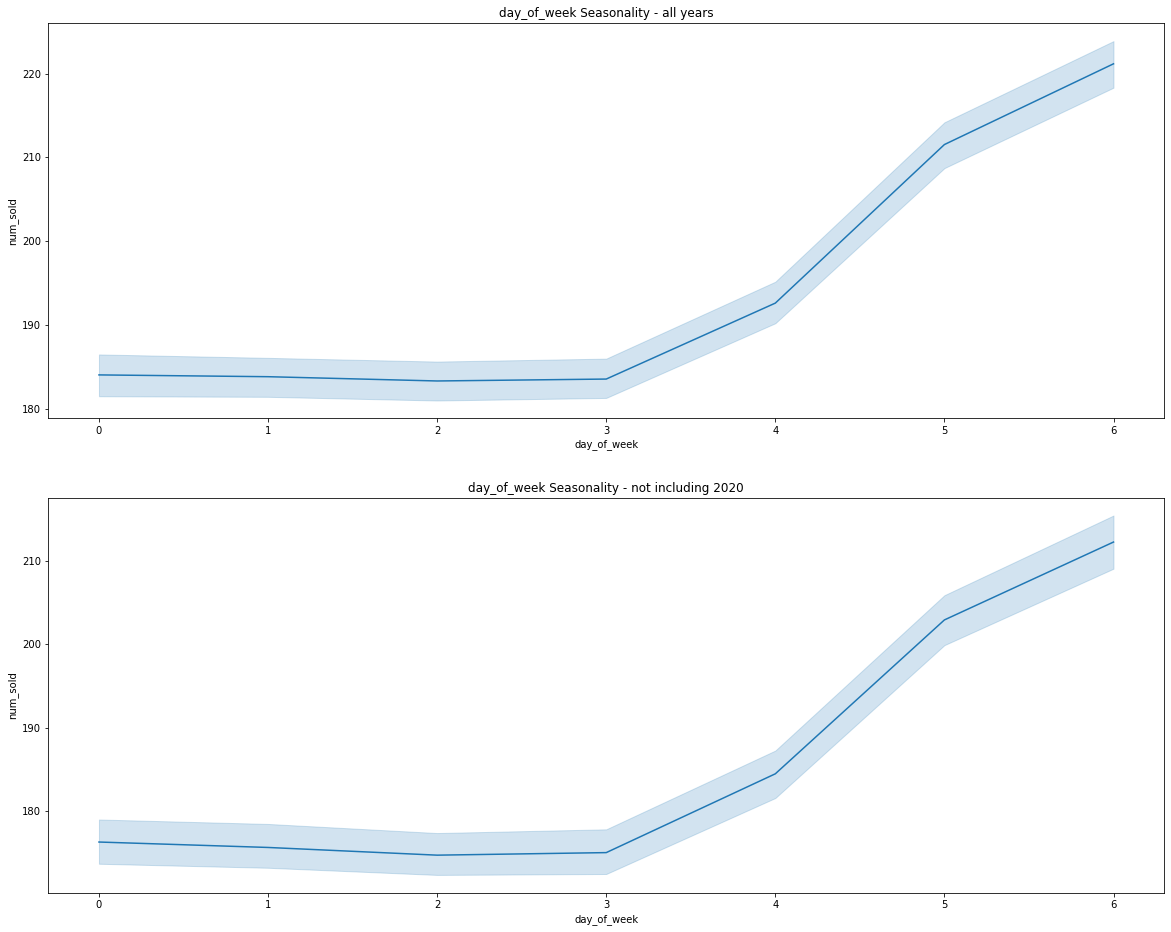

In [154]:
plot_seasonality(train_radio, "day_of_week")

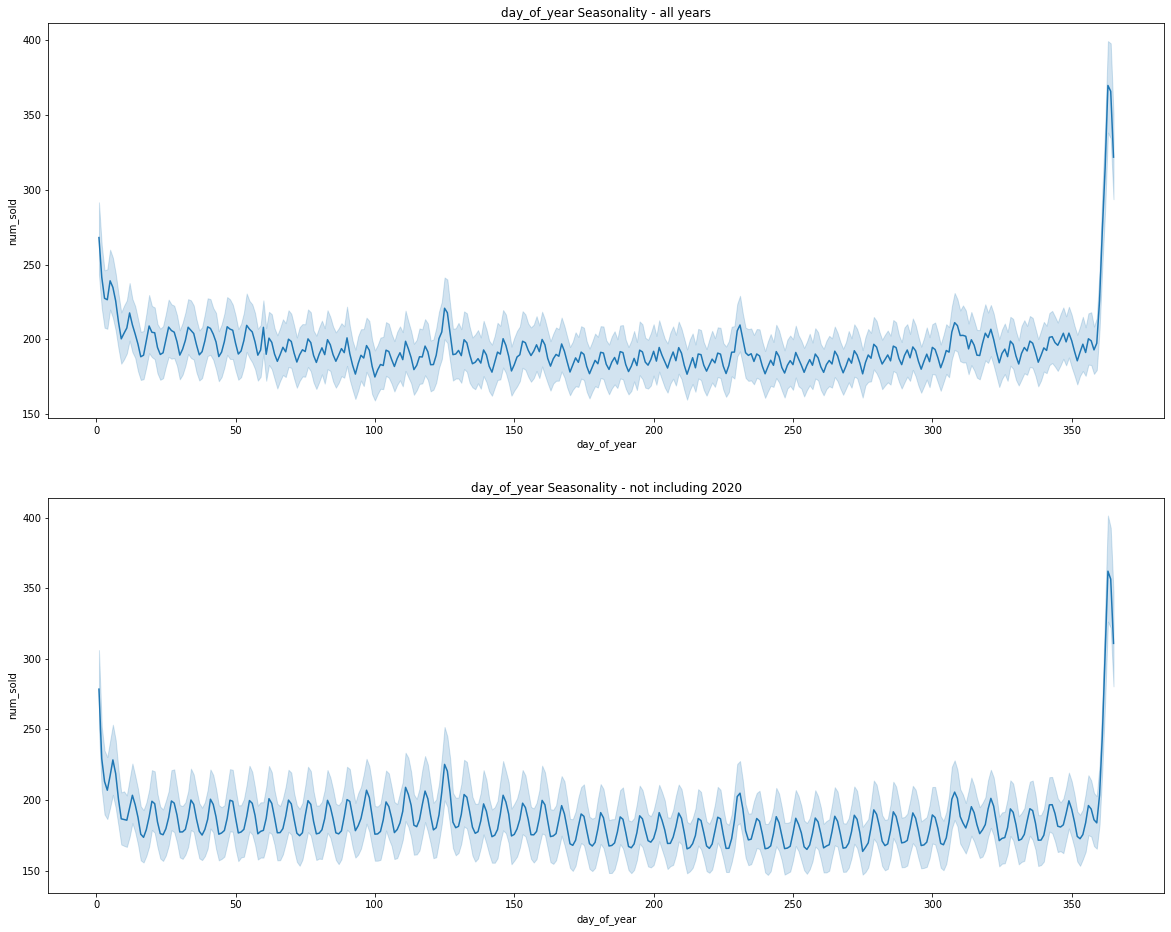

In [155]:
plot_seasonality(train_radio, "day_of_year")

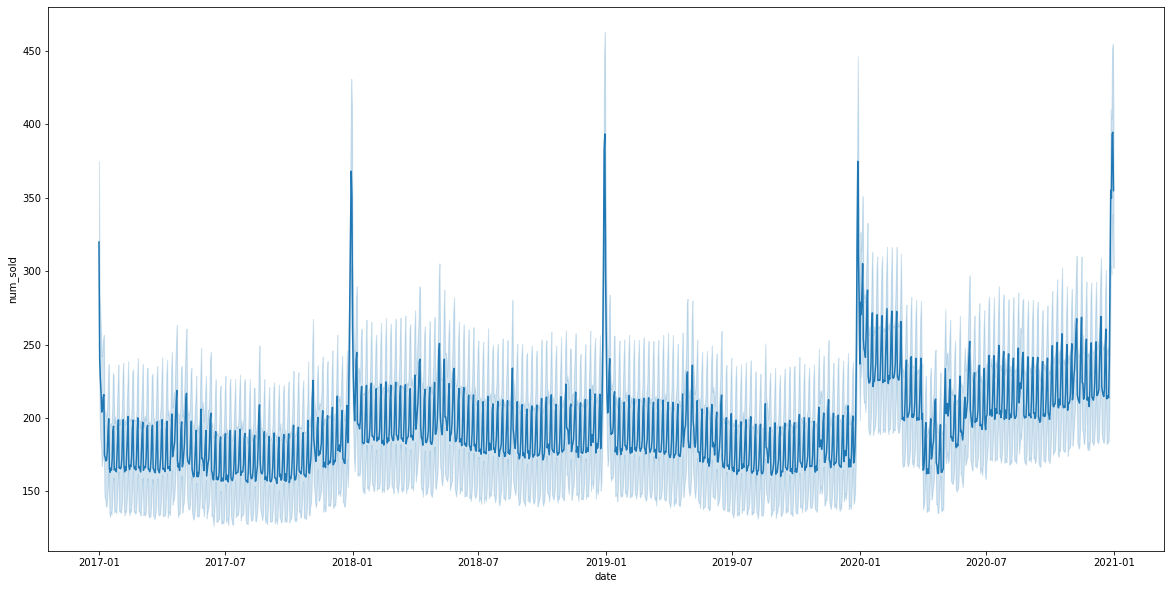

In [156]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = train_radio, x="date", y="num_sold");

In [157]:
train_radio

row_id       date  country       store  \
0           0 2017-01-01  Belgium  KaggleMart   
1           1 2017-01-01  Belgium  KaggleMart   
2           2 2017-01-01  Belgium  KaggleMart   
3           3 2017-01-01  Belgium  KaggleMart   
4           4 2017-01-01  Belgium  KaggleRama   
...       ...        ...      ...         ...   
70123   70123 2020-12-31    Spain  KaggleMart   
70124   70124 2020-12-31    Spain  KaggleRama   
70125   70125 2020-12-31    Spain  KaggleRama   
70126   70126 2020-12-31    Spain  KaggleRama   
70127   70127 2020-12-31    Spain  KaggleRama   

                                product  num_sold  store_rate  country_rate  \
0            Kaggle Advanced Techniques       663    0.736972      0.216258   
1                Kaggle Getting Started       615    0.736972      0.216258   
2                    Kaggle Recipe Book       480    0.736972      0.216258   
3      Kaggle for Kids: One Smart Goose       710    0.736972      0.216258   
4            Kaggle Advanced Techniques       240    0.263028      0.216258   
...                                 ...       ...         ...           ...   
70123  Kaggle for Kids: One Smart Goose       614    0.738594      0.159474   
70124        Kaggle Advanced Techniques       215    0.261406      0.159474   
70125            Kaggle Getting Started       158    0.261406      0.159474   
70126                Kaggle Recipe Book       135    0.261406      0.159474   
70127  Kaggle for Kids: One Smart Goose       202    0.261406      0.159474   

       product_total_sell  product_radio  month  day_of_week  day_of_year  
0                    4267       0.277944      1            6            1  
1                    3492       0.227462      1            6            1  
2                    2900       0.188900      1            6            1  
3                    4693       0.305693      1            6            1  
4                    4267       0.277944      1            6            1  
...                   ...            ...    ...          ...          ...  
70123                4982       0.292525     12            3          365  
70124                4968       0.291703     12            3          365  
70125                3780       0.221948     12            3          365  
70126                3301       0.193823     12            3          365  
70127                4982       0.292525     12            3          365  

[70128 rows x 13 columns]

In [130]:
categorical_features_names = ['country', 'store', 'product']

In [132]:
train_radio[categorical_features_names].nunique()

country    6
store      2
product    4
dtype: int64

In [133]:
from catboost import CatBoostRegressor
X_train = train_radio.drop(['num_sold'], axis = 1)
y_train = train_radio['num_sold'].copy()

model = CatBoostRegressor(n_estimators=200, random_state = 42, cat_features = categorical_features_names)
model.fit(X_train, y_train)

Learning rate set to 0.296547
0:	learn: 92.3853635	total: 197ms	remaining: 39.2s
1:	learn: 67.8997205	total: 231ms	remaining: 22.9s
2:	learn: 50.4507012	total: 270ms	remaining: 17.7s
3:	learn: 38.0947058	total: 301ms	remaining: 14.8s
4:	learn: 29.1191981	total: 334ms	remaining: 13s
5:	learn: 23.1417191	total: 367ms	remaining: 11.9s
6:	learn: 19.0043942	total: 400ms	remaining: 11s
7:	learn: 16.1417821	total: 432ms	remaining: 10.4s
8:	learn: 14.4312789	total: 462ms	remaining: 9.81s
9:	learn: 13.3404220	total: 493ms	remaining: 9.37s
10:	learn: 12.6960034	total: 524ms	remaining: 9s
11:	learn: 12.2833766	total: 556ms	remaining: 8.71s
12:	learn: 12.0239553	total: 587ms	remaining: 8.44s
13:	learn: 11.8076691	total: 621ms	remaining: 8.24s
14:	learn: 11.6752811	total: 653ms	remaining: 8.05s
15:	learn: 11.4900914	total: 686ms	remaining: 7.89s
16:	learn: 11.3684378	total: 719ms	remaining: 7.74s
17:	learn: 11.2991571	total: 750ms	remaining: 7.58s
18:	learn: 11.2255085	total: 782ms	remaining: 7.45s

165:	learn: 9.5376901	total: 5.61s	remaining: 1.15s
166:	learn: 9.5367002	total: 5.64s	remaining: 1.11s
167:	learn: 9.5342948	total: 5.67s	remaining: 1.08s
168:	learn: 9.5305393	total: 5.71s	remaining: 1.05s
169:	learn: 9.5276300	total: 5.74s	remaining: 1.01s
170:	learn: 9.5257270	total: 5.77s	remaining: 979ms
171:	learn: 9.5243169	total: 5.8s	remaining: 945ms
172:	learn: 9.5231980	total: 5.83s	remaining: 911ms
173:	learn: 9.5226867	total: 5.86s	remaining: 876ms
174:	learn: 9.5226451	total: 5.89s	remaining: 841ms
175:	learn: 9.5196178	total: 5.92s	remaining: 808ms
176:	learn: 9.5166404	total: 5.96s	remaining: 774ms
177:	learn: 9.5148588	total: 5.99s	remaining: 740ms
178:	learn: 9.5116621	total: 6.06s	remaining: 711ms
179:	learn: 9.5084271	total: 6.11s	remaining: 679ms
180:	learn: 9.5052452	total: 6.18s	remaining: 648ms
181:	learn: 9.5051955	total: 6.21s	remaining: 614ms
182:	learn: 9.5043354	total: 6.29s	remaining: 585ms
183:	learn: 9.5042495	total: 6.32s	remaining: 550ms
184:	learn: 9

In [134]:
test_radio = test.copy()

In [136]:
def radio_rate(df):
    data = df.copy()
    data['store_rate'] = (data.groupby(["date",'store'])["num_sold"].sum() / data.groupby(["date"])["num_sold"].sum())
    data['country_rate'] = (data.groupby(["date",'country'])["num_sold"].sum() / data.groupby(["date"])["num_sold"].sum())
    data['product_total_sell'] = (data.groupby(["date",'store'])["num_sold"].sum() / data.groupby(["date"])["num_sold"].sum())
    return data

In [137]:
test_radio = radio_rate(test_radio)
test_radio

KeyError: 'Column not found: num_sold'

In [138]:
test

row_id       date  country       store  \
0       70128 2021-01-01  Belgium  KaggleMart   
1       70129 2021-01-01  Belgium  KaggleMart   
2       70130 2021-01-01  Belgium  KaggleMart   
3       70131 2021-01-01  Belgium  KaggleMart   
4       70132 2021-01-01  Belgium  KaggleRama   
...       ...        ...      ...         ...   
17515   87643 2021-12-31    Spain  KaggleMart   
17516   87644 2021-12-31    Spain  KaggleRama   
17517   87645 2021-12-31    Spain  KaggleRama   
17518   87646 2021-12-31    Spain  KaggleRama   
17519   87647 2021-12-31    Spain  KaggleRama   

                                product  
0            Kaggle Advanced Techniques  
1                Kaggle Getting Started  
2                    Kaggle Recipe Book  
3      Kaggle for Kids: One Smart Goose  
4            Kaggle Advanced Techniques  
...                                 ...  
17515  Kaggle for Kids: One Smart Goose  
17516        Kaggle Advanced Techniques  
17517            Kaggle Getting Started  
17518                Kaggle Recipe Book  
17519  Kaggle for Kids: One Smart Goose  

[17520 rows x 5 columns]

In [83]:
# from sklearn.preprocessing import LabelEncoder
# def change_data(data):
#     data['date'] = pd.to_datetime(data['date'])
#     data['year'] = data['date'].dt.year
#     data['month'] = data['date'].dt.month
#     data['day'] = data['date'].dt.day
#     data['dayofweek'] = data['date'].dt.dayofweek
#     data['quarter'] = data['date'].dt.quarter
    
#     data['country'] = LabelEncoder().fit_transform(data['country'])
#     data['store'] = LabelEncoder().fit_transform(data['store'])
#     data['product'] = LabelEncoder().fit_transform(data['product'])
#     return data

# train_change = change_data(train)
# test_change = change_data(test)
# train_change

row_id       date  country  store  product  num_sold  year  month  day  \
0           0 2017-01-01        0      0        0       663  2017      1    1   
1           1 2017-01-01        0      0        1       615  2017      1    1   
2           2 2017-01-01        0      0        2       480  2017      1    1   
3           3 2017-01-01        0      0        3       710  2017      1    1   
4           4 2017-01-01        0      1        0       240  2017      1    1   
...       ...        ...      ...    ...      ...       ...   ...    ...  ...   
70123   70123 2020-12-31        5      0        3       614  2020     12   31   
70124   70124 2020-12-31        5      1        0       215  2020     12   31   
70125   70125 2020-12-31        5      1        1       158  2020     12   31   
70126   70126 2020-12-31        5      1        2       135  2020     12   31   
70127   70127 2020-12-31        5      1        3       202  2020     12   31   

       dayofweek  quarter  
0              6        1  
1              6        1  
2              6        1  
3              6        1  
4              6        1  
...          ...      ...  
70123          3        4  
70124          3        4  
70125          3        4  
70126          3        4  
70127          3        4  

[70128 rows x 11 columns]

In [84]:
test_change

row_id       date  country  store  product  year  month  day  \
0       70128 2021-01-01        0      0        0  2021      1    1   
1       70129 2021-01-01        0      0        1  2021      1    1   
2       70130 2021-01-01        0      0        2  2021      1    1   
3       70131 2021-01-01        0      0        3  2021      1    1   
4       70132 2021-01-01        0      1        0  2021      1    1   
...       ...        ...      ...    ...      ...   ...    ...  ...   
17515   87643 2021-12-31        5      0        3  2021     12   31   
17516   87644 2021-12-31        5      1        0  2021     12   31   
17517   87645 2021-12-31        5      1        1  2021     12   31   
17518   87646 2021-12-31        5      1        2  2021     12   31   
17519   87647 2021-12-31        5      1        3  2021     12   31   

       dayofweek  quarter  
0              4        1  
1              4        1  
2              4        1  
3              4        1  
4              4        1  
...          ...      ...  
17515          4        4  
17516          4        4  
17517          4        4  
17518          4        4  
17519          4        4  

[17520 rows x 10 columns]

In [85]:
train_change.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70128 entries, 0 to 70127
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   row_id     70128 non-null  int64         
 1   date       70128 non-null  datetime64[ns]
 2   country    70128 non-null  int64         
 3   store      70128 non-null  int64         
 4   product    70128 non-null  int64         
 5   num_sold   70128 non-null  int64         
 6   year       70128 non-null  int64         
 7   month      70128 non-null  int64         
 8   day        70128 non-null  int64         
 9   dayofweek  70128 non-null  int64         
 10  quarter    70128 non-null  int64         
dtypes: datetime64[ns](1), int64(10)
memory usage: 5.9 MB


이 챌린지에서는 6개국에 있는 두 개의 경쟁 매장에서 4개 품목에 대한 1년 동안의 매출을 예측합니다. 이 데이터 세트는 완전히 허구이지만 실제 데이터에서 볼 수 있는 많은 효과(예: 주말 및 공휴일 효과, 계절성 등)가 포함되어 있습니다. 2021년 동안 책 판매를 예측하는 어려운 작업이 주어집니다.

In [86]:
X_train_drop = train_change.drop(['num_sold', 'date', 'row_id'], axis = 1)
X_train_drop_ = train_change.drop(['num_sold', 'row_id'], axis = 1)

y_train_drop = train_change['num_sold']
test_drop = test_change.drop(['date', 'row_id'], axis = 1)

In [87]:
X_train_drop

country  store  product  year  month  day  dayofweek  quarter
0            0      0        0  2017      1    1          6        1
1            0      0        1  2017      1    1          6        1
2            0      0        2  2017      1    1          6        1
3            0      0        3  2017      1    1          6        1
4            0      1        0  2017      1    1          6        1
...        ...    ...      ...   ...    ...  ...        ...      ...
70123        5      0        3  2020     12   31          3        4
70124        5      1        0  2020     12   31          3        4
70125        5      1        1  2020     12   31          3        4
70126        5      1        2  2020     12   31          3        4
70127        5      1        3  2020     12   31          3        4

[70128 rows x 8 columns]

In [88]:
test_drop

country  store  product  year  month  day  dayofweek  quarter
0            0      0        0  2021      1    1          4        1
1            0      0        1  2021      1    1          4        1
2            0      0        2  2021      1    1          4        1
3            0      0        3  2021      1    1          4        1
4            0      1        0  2021      1    1          4        1
...        ...    ...      ...   ...    ...  ...        ...      ...
17515        5      0        3  2021     12   31          4        4
17516        5      1        0  2021     12   31          4        4
17517        5      1        1  2021     12   31          4        4
17518        5      1        2  2021     12   31          4        4
17519        5      1        3  2021     12   31          4        4

[17520 rows x 8 columns]

In [89]:
X_train_drop

country  store  product  year  month  day  dayofweek  quarter
0            0      0        0  2017      1    1          6        1
1            0      0        1  2017      1    1          6        1
2            0      0        2  2017      1    1          6        1
3            0      0        3  2017      1    1          6        1
4            0      1        0  2017      1    1          6        1
...        ...    ...      ...   ...    ...  ...        ...      ...
70123        5      0        3  2020     12   31          3        4
70124        5      1        0  2020     12   31          3        4
70125        5      1        1  2020     12   31          3        4
70126        5      1        2  2020     12   31          3        4
70127        5      1        3  2020     12   31          3        4

[70128 rows x 8 columns]

In [90]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# plt.figure(figsize=(16,5))
# ax = sns.barplot(data=train, x=X_train['store'], y=y_train, hue=X_train['date'])
# ax.legend().remove()
# plt.title('Product distribution grouped by country')
# plt.show()

In [91]:
# plt.figure(figsize=(16,5))
# ax = sns.barplot(data=train, x=X_train['product'], y=y_train, hue=X_train['country'])
# ax.legend().remove()
# ax.set(xticklabels = [])
# plt.title('Product distribution grouped by country')
# plt.show()

In [92]:
# fig, ax = plt.subplots(4, 1, figsize=(18, 20))
# ax = ax.flatten()

# for i, product in enumerate(train['product'].unique()):
#     subset = train[train['product'] == product]
#     sns.lineplot(ax=ax[i], data=subset.groupby(['date','country']).sum(), x='date', y='num_sold', hue='country')
#     plt.ylim([0,1400])
    
#     ax[i].set_title(product)
#     ax[i].set(xlabel = None)
    
#     ax[i].legend(loc='upper right')
#     if i!=2:
#         ax[i].legend().remove()

# fig.tight_layout()

In [93]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from xgboost import XGBRegressor, plot_importance
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [98]:
# X_train, X_val, y_train, y_val = train_test_split(X_train_drop, y_train_, random_state=42, shuffle = False)
X_train = X_train_drop
y_train = y_train_drop
X_train_time, X_val_time = train_test_split(X_train_drop_, random_state=42, shuffle = False)

In [104]:
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor(application  = 'regression', n_estimators = 150, random_state = 42)
lgbm.fit(X_train, y_train)

LGBMRegressor(application='regression', n_estimators=150, random_state=42)

In [105]:
xgb = XGBRegressor(random_state = 42, n_estimators = 150)
xgb_grid = {
    'n_estimators' : [25, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500],
    'max_depth' : [2, 3, 4, 5, 6, 7, 8, 9],
    'gamma' : [0, 0.1, 0.07, 0.05, 0.03, 0.01],
    'min_child_weight' : [1, 2, 3, 4, 5, 6],
    'subsample' : [0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'colsample_bytree' : [0.5, 0.7, 0.9, 1]
}
# xgb_search = GridSearchCV(xgb, param_grid = xgb_grid, cv = 5, verbose = 1)
# xgb_search = RandomizedSearchCV(xgb, param_distributions = xgb_grid, n_iter = 100, cv = 5, verbose = 1, random_state = 42)
# xgb_search.fit(X_train, y_train)
# print(xgb_search.best_params_)
# xgb = XGBRegressor(random_state = 42, n_estimators = xgb_search.best_params_['n_estimators'],
#                   max_depth = xgb_search.best_params_['max_depth'], gamma = xgb_search.best_params_['gamma'],
#                   min_child_weight = xgb_search.best_params_['min_child_weight'],
#                   subsample = xgb_search.best_params_['subsample'],
#                   colsample_bytree = xgb_search.best_params_['colsample_bytree'])
xgb.fit(X_train, y_train)

# cat_2 = CatBoostRegressor(verbose = 0, iterations = 1000, random_state=42)
# cat_2.fit(X_train_cate, y_train_cate, cat_features=train_data.columns[train_data.dtypes == 'object'].to_list())

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=150, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

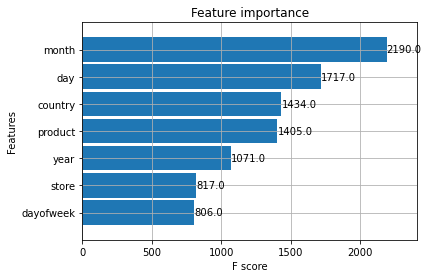

In [106]:
plot_importance(xgb, height=0.9)

In [107]:
cat_1 = CatBoostRegressor(verbose = 0, random_state = 42)
cat_1.fit(X_train, y_train)

In [108]:
vot = VotingRegressor(estimators=[('cat', cat_1), ('xgb', xgb), ('lgbm', lgbm)])
vot.fit(X_train, y_train)

VotingRegressor(estimators=[('cat',
                             <catboost.core.CatBoostRegressor object at 0x000002A79D31C400>),
                            ('xgb',
                             XGBRegressor(base_score=0.5, booster='gbtree',
                                          callbacks=None, colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=0, gpu_id=-1,
                                          grow_policy='depthwise',
                                          importance_type=No...
                                          learning_rate=0.300000012,
                                          max_bin=256, max_cat_to_onehot=4,
                                          max_delta_step=0, max_depth=6,
                                          max_leaves=0, min_child_weight=1,
                                          missing=nan,
                                          monotone_constraints='()',
                                          n_estimators=150, n_jobs=0,
                                          num_parallel_tree=1, predictor='auto',
                                          random_state=42, reg_alpha=0,
                                          reg_lambda=1, ...)),
                            ('lgbm',
                             LGBMRegressor(application='regression',
                                           n_estimators=150,
                                           random_state=42))])

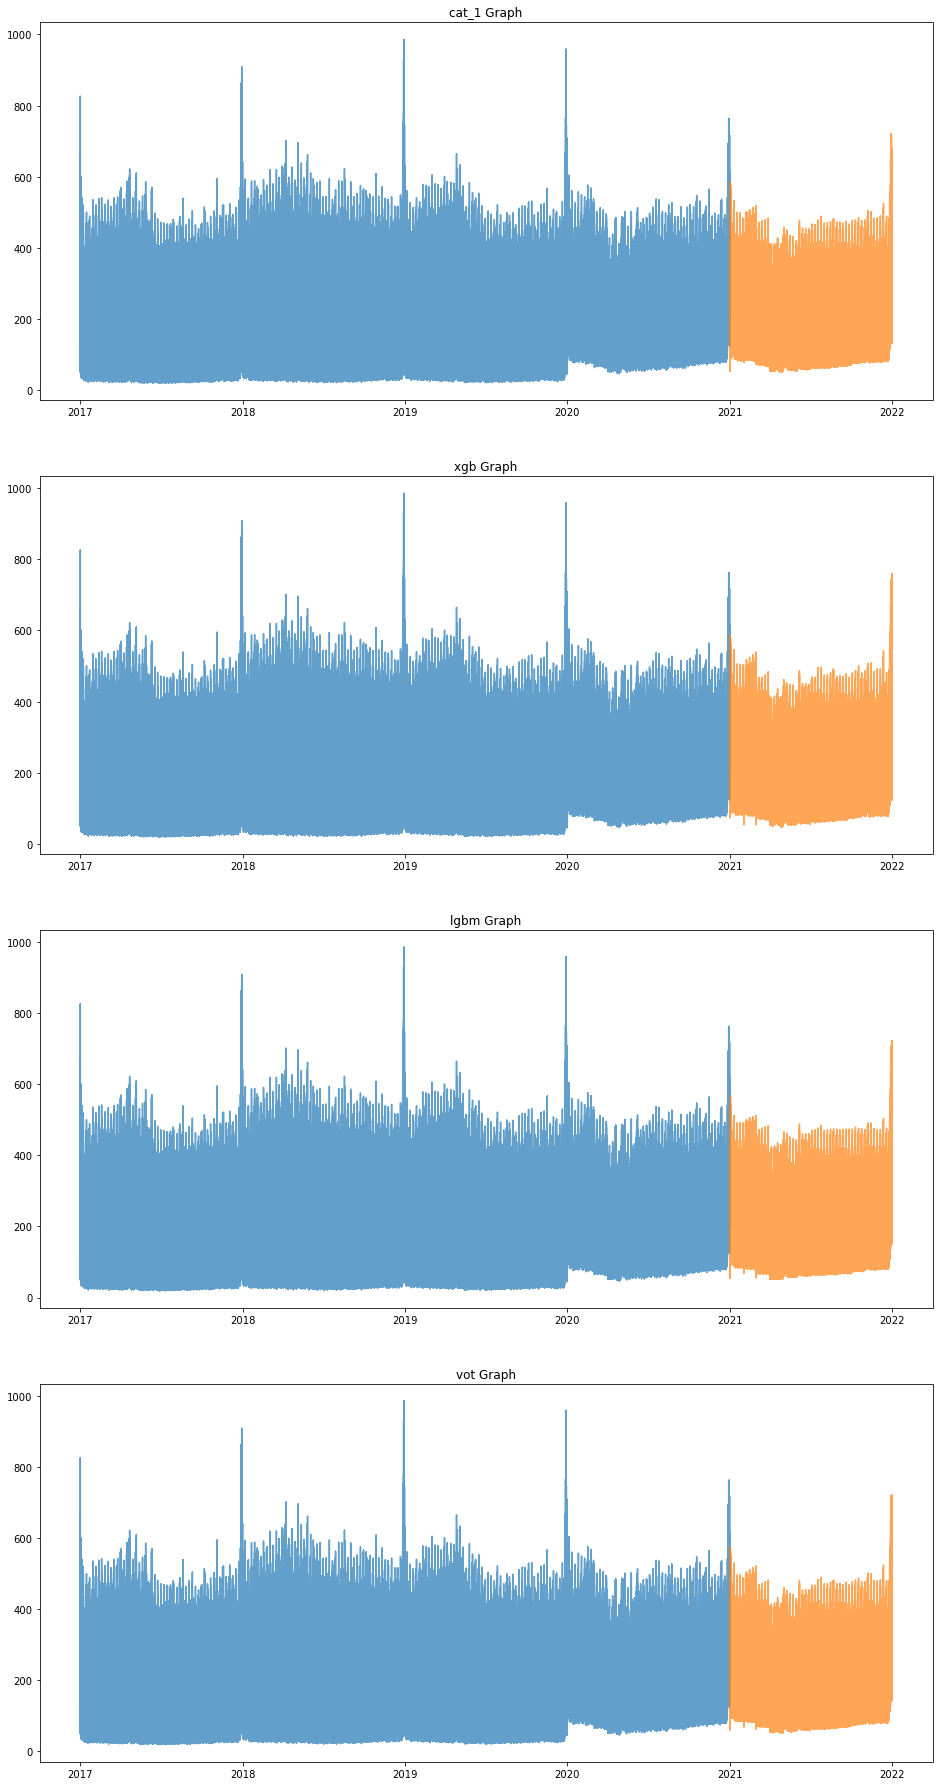

In [109]:
import matplotlib.pyplot as plt
cat_plot = cat_1.predict(test_drop)
xgb_plot = xgb.predict(test_drop)
lgbm_plot = lgbm.predict(test_drop)
vot_plot = vot.predict(test_drop)


plt.figure(figsize=(16,32))

plt.subplot(4, 1, 1)
plt.title('cat_1 Graph')
plt.plot(train['date'], y_train, test['date'], cat_plot, alpha = 0.7)

plt.subplot(4, 1, 2)
plt.title('xgb Graph')
plt.plot(train['date'], y_train, test['date'], xgb_plot, alpha = 0.7)

plt.subplot(4, 1, 3)
plt.title('lgbm Graph')
plt.plot(train['date'], y_train, test['date'], lgbm_plot, alpha = 0.7)

plt.subplot(4, 1, 4)
plt.title('vot Graph')
plt.plot(train['date'], y_train, test['date'], vot_plot, alpha = 0.7)
plt.show()

In [110]:
from sklearn.model_selection import cross_val_predict
print(cross_val_predict(cat_1, X_train, y_train, cv = 5).mean())
print(cross_val_predict(xgb, X_train, y_train, cv = 5).mean())
print(cross_val_predict(lgbm, X_train, y_train, cv = 5).mean())
print(cross_val_predict(vot, X_train, y_train, cv = 5).mean())

194.3012658345072
193.77687
193.5915674795427
193.88989649995926


In [111]:
# cross_val_predict(cat_2, X_train, y_train, cv = 10).mean()

In [112]:
# test_cate

In [113]:
predictions_1 = cat_1.predict(test_drop)
predictions_2 = xgb.predict(test_drop)
predictions_3 = lgbm.predict(test_drop)
predictions_4 = vot.predict(test_drop)
# predictions_2 = cat_2.predict(test_cate)

In [114]:
predictions_1

array([513.27130647, 413.6404031 , 365.56052815, ..., 170.64973478,
       145.37225435, 225.65943466])

In [115]:
predictions_2

array([510.30182, 420.24216, 362.55313, ..., 139.27776, 123.26744,
       201.01575], dtype=float32)

In [116]:
predictions_3

array([480.49699114, 372.53179627, 330.68293641, ..., 191.70324492,
       165.20368948, 237.85985877])

In [117]:
predictions_4

array([501.35670549, 402.13811878, 352.93219856, ..., 167.21024515,
       144.61446154, 221.51168017])

In [118]:
# predictions_2

In [119]:
output = pd.DataFrame({'row_id': test.row_id, 'num_sold': predictions_4})
output.to_csv('cat_xgb_lgbm.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
